In [1]:
# Importing the necessary libraries

import math
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import simpy

# Utilities

## Plotting

In [2]:
def plotMap(G, T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='ro', msW=9,
            text=None, grid=False, size=6):
    fig = plt.gcf()
    fig.set_size_inches(size, size)
    resolution = 10000
    plt.xlim(0,resolution)
    plt.ylim(0,resolution)
    if not grid:
        plt.axis('off')
    V, E = G
    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if grid:
        plt.grid()
        if text is not None:
            plt.title(text)
    else:
        if text is not None:
            plt.text(0.8*resolution, 0, text)

    plt.show()

In [3]:
import scipy.stats as stats

def histplot(data, title="", xlabel="",
             width=None, height=None):
    
    minx = min(data)
    maxx = max(data)
    μ = np.mean(data)
    σ = np.std(data)
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 4)
    fig.set_figheight(height if height is not None else 2.5)
    ax = fig.gca()
        
    bins=min(50, min(len(data),maxx-minx)//5+1)
    hist=plt.hist(data, density=True, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)
        
    x = np.linspace(minx, maxx, 100)
    y = [ stats.norm(loc=μ, scale=σ).pdf(p) for p in x]
    ax.plot(x, y, lw=1, color='red')
    ax.axvline(x=μ, color='red')
    maxy = max(max(y), max(hist[0]))
    ax.text(maxx, maxy, 
            f'μ={μ:2.2f}\nσ={σ:2.2f}', 
            ha='right', va='top', 
            color='red', fontsize=12)
    ax.grid(True)
    plt.show()

In [4]:
def dailyPlot(data,
              title="", ylabel="",
              width=None, height=None):
    
    days = len(data)
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 6)
    fig.set_figheight(height if height is not None else 2)
    
    ax = fig.gca()
    diff = (max(data)-min(data))*0.1
    ymin = int(math.floor(min(data)-diff))
    ymax = int(math.ceil(max(data)+diff))
    ax.set_xlim(-1, days)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
    
    ms = 2 if len(data)>100 else 5
    lw = 0.5 if len(data)>100 else 1

    x = np.arange(0, len(data))
    y = np.array([ y for y in data ])
    b, m = np.polynomial.polynomial.polyfit(x, y, 1)
    
    plt.plot(x, y, 'bo-', linewidth=lw, markersize=ms)
    plt.plot(x, m*x+b, 'r-')
    
    plt.xlabel('Day')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [5]:
def barPlot(count, title=''):
    fig = plt.figure()
    fig.set_figwidth(3 if len(count)<=10 else 5)
    fig.set_figheight(2)
    ax = fig.gca()
    xpos = np.arange(0, len(count))
    labels = [ c for c in range(0, len(count)) ]
    ax.set_xticks(xpos, labels)
    plt.title(title)
    plt.bar(range(0, len(count)), count)

## Geometry

In [6]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.ceil(math.sqrt((x1-x2)**2+(y1-y2)**2)))

In [7]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

## Time Handling

**Convention:** In this project we measure time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

In [8]:
def day(now):
    return int(now//(24*3600))

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`. It will be used for trace messages.

In [9]:
def timestamp(t):
    day = int(t)//(24*3600)
    t = t - day*24*3600
    hour = int(t)//3600
    t = t - hour*3600
    mins = int(t)//60
    t = t - mins*60
    secs = int(t)
    t = int(round((t - secs)*10))
    return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [10]:
timestamp(24*3600*5+23*3600+34*60+12.1)

'[ 5] 23:34:12.1'

`nextHour` generates the simulation time for the next time the hour is equal to the requested hour. 

In [11]:
def nextHour(env, hour):
    beginningOfDay = day(env.now)*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

# Generation of Input Data

## Generate Parcels

`generateParcels` returns for each day a list of customers that should receive parcels on that day. The data are generated for a given number of customers and days under assumption that the demand is independent and identically distributed with a mean value 

In [12]:
def generateParcels(days=50, customers=100, 
                    p=0.25, plot=False, log=False):

    # daily delivery demand is generated for each customer 
    # independently using an expovariate distribution
    
    parcelsForCustomersPerDay = [ [] for i in range(days) ]
    parcelsPerCustomer = [ 0 for i in range(customers) ]
    parcelsPerDay = [ 0 for i in range(days) ]

    for c in range(customers):
        cp = []
        t = random.expovariate(p/(24*3600)) # arrival time secs
        d = day(t)
        deliveryDays = []
        while d<days:
            if d not in deliveryDays:
                deliveryDays.append(d)
            parcelsForCustomersPerDay[d].append(c)
            parcelsPerDay[d] += 1
            parcelsPerCustomer[c] += 1
            if d not in cp:
                cp.append(d)
            t += random.expovariate(p/(24*3600))
            d = day(t)
        
        if log:
            print(f"customer {c:3d} "
                  f"expects {parcelsPerCustomer[c]:2d} deliveries "
                  f"on days {str(cp):s}")
    
    if plot:
        
        histplot(parcelsPerCustomer,
                 xlabel=f'Number of Parcels (over {days:3,d} days, p={p:2.2f})',
                 title=f'Number of Parcels per Customer (N={customers:3,d})')
        
        histplot(parcelsPerDay,
                 xlabel=f'Number of Parcels (over {customers:3,d} customers, p={p:2.2f})',
                 title=f'Number of Parcels per Day (N={days:3,d})')
        
    return parcelsForCustomersPerDay

## Testing Parcel Data Generation

In [13]:
random.seed(0)
generateParcels(days=5, customers=8, p=0.3, log=True)

customer   0 expects  0 deliveries on days []
customer   1 expects  1 deliveries on days [4]
customer   2 expects  2 deliveries on days [0, 3]
customer   3 expects  0 deliveries on days []
customer   4 expects  2 deliveries on days [1, 3]
customer   5 expects  0 deliveries on days []
customer   6 expects  2 deliveries on days [2, 3]
customer   7 expects  2 deliveries on days [3, 4]


[[2], [4], [6], [2, 4, 6, 7], [1, 7]]

## Statistical Analysis of Parcel Data

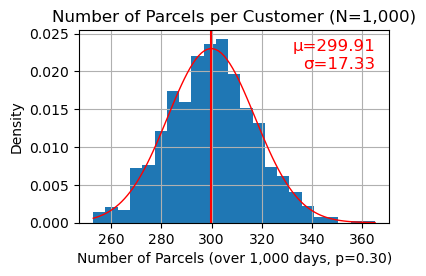

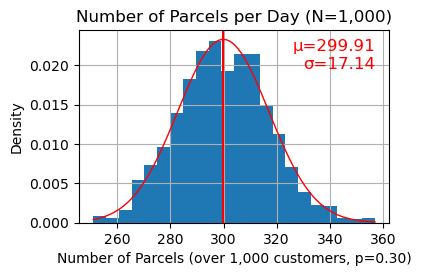

In [14]:
random.seed(0)
_ = generateParcels(days=1000, customers=1000, p=0.3, plot=True)

# Shortest Path Finding

## A* Algorithm

In [15]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

## Floyd-Warshall Algorithm

The following is a modified 
[Floyd-Warshall Algorithm](https://en.wikipedia.org/wiki/Floyd–Warshall_algorithm)
calculating in parallel the distances and the shortest path between vertices in a graph M.

In [16]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

## Testing Shortest Path

In [17]:
import pickle
with open('sampleData.pickled', 'rb') as f:
    M, W, C = pickle.load(f)

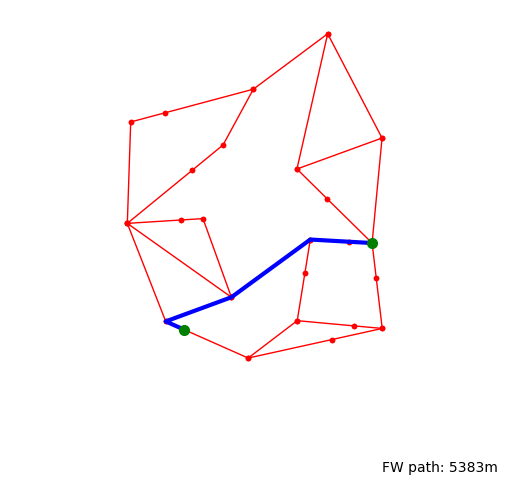

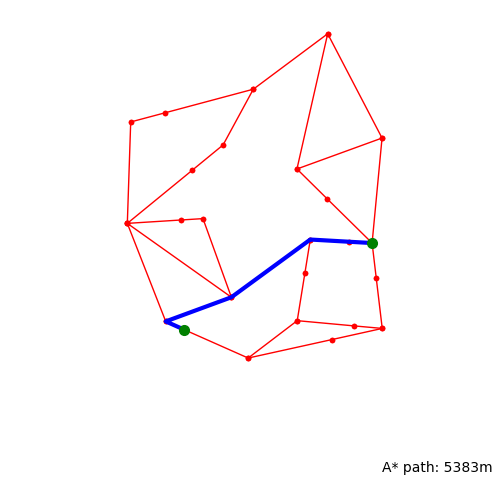

True

In [18]:
V, E = M
d, p = FW(M)
random.seed(0)
[A, B] = random.sample(V, k=2)
a = V.index(A)
b = V.index(B)
P1 = p[a][b]
L1 = d[a][b]
plotMap(M, T=[A, B], P=P1, text=f"FW path: {L1:d}m")
P2 = shortestPath(M, A, B)
L2 = pathLength(P2)
plotMap(M, T=[A, B], P=P2, text=f"A* path: {L2:d}m")
P1==P2

# Create Roundtrip

## Using Iterative Integer Programming

In [19]:
import pulp

In [20]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [21]:
def createLoop(M, D, P, T):
    V, E = M
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[V.index(T[i])][V.index(T[j])]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    # print(f"{constraints:d} Constraints")
    prob.solve(solver)
    trips = roundtrips(x, n)
    while len(trips)>1:
        for t in trips:
            prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                            for i in range(0,len(t)-1) ]) <= len(t)-2
            constraints += 1
        # print(f"{constraints:d} Constraints")
        prob.solve(solver)
        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[V.index(T[trip[k]])][V.index(T[trip[k+1]])]
        loop += sub if len(loop)==0 else sub[1:]
    return loop

## Using Heuristic Method

In [22]:
def createLoopH(M, D, P, T, plot=False):
    
    def makeLoop(L):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop
    
    V, E = M
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:3]+[T[0]]
        T = T[3:]
        while len(T)>0:
            if plot:
                loop = makeLoop(L)
                plotMap(M, T=L, P=loop, w=W, 
                        grid=True, text=f"{pathLength(loop):,d}m")
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
    return makeLoop(L)

## Testing Generating Roundtrip

In [23]:
import pickle
with open('sampleData.pickled', 'rb') as f:
    M, W, C = pickle.load(f)

In [24]:
D, P = FW(M)

In [25]:
random.seed(0)
customers = random.sample(C, k=5)

In [26]:
L = createLoop(M, D, P, [W]+customers)

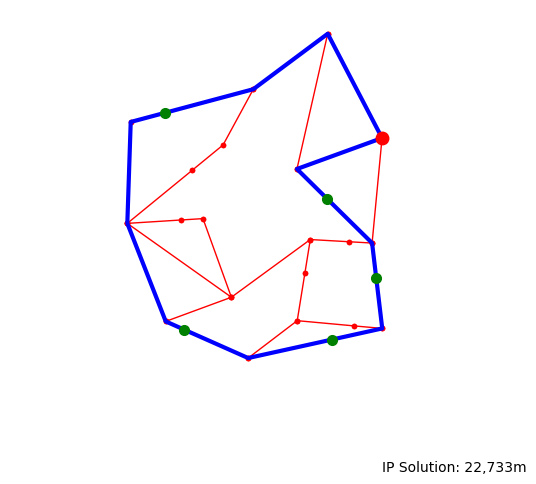

In [27]:
plotMap(M, T=customers, P=L, w=W, 
        text=f"IP Solution: {pathLength(L):,d}m")

In [28]:
L2 = createLoopH(M, D, P, [W]+customers)

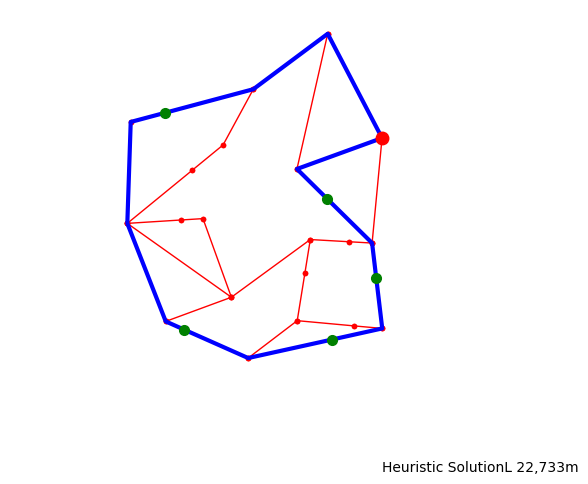

In [29]:
plotMap(M, T=customers, P=L, w=W, 
        text=f"Heuristic SolutionL {pathLength(L):,d}m")

# Recorder

In [30]:
def combineRecorders(recs): 
    M = recs[0].M
    W = recs[0].W
    C = recs[0].C
    days = sum( [ rec.days for rec in recs ] )
    parcels = sum( [ rec.parcels for rec in recs ])
    # ensure the models are compatible
    for rec in recs[1:]:
        assert(M == rec.M)
        assert(W == rec.W)
        assert(C == rec.C)
        
    r = Recorder(None, M, W, C, days, parcels)
    
    # join the data frames
    r.daily = pd.concat([ rec.daily for rec in recs ], ignore_index=True)
    r.precs = pd.concat([ rec.precs for rec in recs ], ignore_index=True)
    return r

In [31]:
class Recorder:
    
    def __init__(self, env, M, W, C, days, parcels,
                 log=False, plot=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.parcels = parcels
        self.log = log
        self.plot = plot
        Customer.REGISTER = []
        Parcel.REGISTER = []
                
        # create a data frame for time records per working day
        self.daily = pd.DataFrame()
        self.daily['begin'] = [None]*days
        self.daily['end'] = [None]*days
        self.daily['dist'] = [None]*days
        self.daily['left'] = [None]*days
        
        # create a data frame for records per parcel
        self.precs = pd.DataFrame()
        self.precs['arrived'] = [None]*parcels
        self.precs['delivered'] = [None]*parcels

    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)

    def recordDriverBeginsWork(self):
        self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'begin'] = int(round(self.env.now))
        
    def recordDriverEndsWork(self):
        self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'end'] = int(round(self.env.now))

    def recordTourLength(self, length):
        self.daily.at[day(self.env.now), 'dist'] = int(length)

    def recordParcelsLeftOver(self, numberOfParcels):
        self.trace(f"{numberOfParcels:d} left over for next day")
        self.daily.at[day(self.env.now), 'left'] = numberOfParcels

    def recordParcelArrival(self, parcel):
        self.trace(f"{str(parcel):s} arrived in delivery centre")
        self.precs.at[parcel.i, 'arrived'] = day(self.env.now)
        
    def recordParcelDelivery(self, parcel):
        self.trace(f"{str(parcel):s} delivered to customer")
        self.precs.at[parcel.i, 'delivered'] = day(self.env.now)

    def finish(self):
        self.daily['time'] = self.daily['end']-self.daily['begin']
        # if at the end of the simulation there are parcels 
        # not yet delivered, register them for the next day
        for i in range(self.parcels):
            if self.precs.at[i, 'delivered'] is None:
                self.precs.at[i, 'delivered'] = self.days
        self.precs['delay'] = self.precs['delivered']-self.precs['arrived']
        # calculate max delay time of parcels delivered on a day
        self.daily['maxdelay'] = [0] * self.days
        for i in range(self.parcels):
            deliveryDay = self.precs.at[i, 'delivered']
            if deliveryDay < self.days:
                if self.daily.at[deliveryDay, 'maxdelay'] < self.precs.at[i, 'delay']:
                    self.daily.at[deliveryDay, 'maxdelay'] = self.precs.at[i, 'delay']
        # simulation is finished for good
        # by removing the simulation environment we can
        # pickle recorder
        self.env = None
        
    def histWorkingTime(self):
        histplot(self.daily['time']//60,
                 xlabel='Working Time [min]',
                 title='Daily Working Time')
        
    def plotWorkingTime(self):
        dailyPlot(self.daily['time']//60,
                  ylabel='Working Time [min]',
                  title='Daily Working Time')
            
    def histTourLength(self):
        histplot(self.daily['dist'],
                 xlabel='Tour Length [m]',
                 title='Daily Tour Length')
            
    def plotTourLength(self):
        dailyPlot(self.daily['dist'],
                  ylabel='Tour Length [m]',
                  title='Daily Tour Length')
            
    def histLeftOver(self):
        histplot(self.daily['left'],
                 xlabel='Left-Over Parcels',
                 title='Daily Left-Over Parcels')
                
    def plotLeftOver(self):
        dailyPlot(self.daily['left'],
                  ylabel='Number of Parcels',
                  title='Daily Left-Over Parcels')
        
    def plotParcelDelay(self):
        dailyPlot(self.daily['maxdelay'],
                  ylabel='Max Delay [days]',
                  title='Max Delivery Delay')
        
    def barplotParcelDelay(self):
        maxDelay = max(self.precs['delay'])
        count = [ 0 for c in range(maxDelay+1) ]
        for i in range(self.parcels):
            count[self.precs.at[i, 'delay']] += 1
        barPlot(count, title='Parcel Delay [days]')
        
    def tableParcelDelay(self):
        maxDelay = max(self.precs['delay'])
        count = [ 0 for c in range(maxDelay+1) ]
        for i in range(self.parcels):
            count[self.precs.at[i, 'delay']] += 1
        print(f'Delivery Delay ({self.parcels:d} parcels)')
        print(f'{"None":>7s}:   {count[0]:4d}   {count[0]/self.parcels*100:4.1f}%')
        for c in range(1, len(count)):
            print(f'{c:2d} days:   {count[c]:4d}   {count[c]/self.parcels*100:4.1f}%')

# Model

## Class Parcel

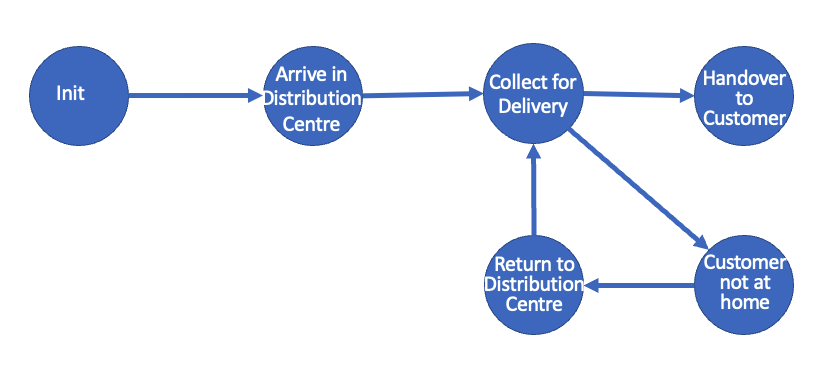

In [32]:
from IPython import display
display.Image("EventGraph Parcel.png")

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery 
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [33]:
class Parcel:
    
    REGISTER = []
    
    def __init__(self, rec, cust):
        self.rec = rec
        self.cust = cust
        self.dest = cust.location
        self.status = [ ] # status record and
        self.timing = [ ] # timing
        self.i = len(Parcel.REGISTER)
        Parcel.REGISTER.append(self)

    def __str__(self):
        return f"Parcel: {self.i:2d} for customer {self.cust.i:d}"
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')
        
    def delivered(self):
        self.rec.recordParcelDelivery(parcel)
        self.__reg('delivered to customer')

## Class Customer

The customer is considered passive. The customer is at home with q given probability `q`. The time to answer the door is
given with an expovariate distribution. When the customer is not answering within a certain period of time, the parcel is returned to the delivery centre.

In [34]:
class Customer:
    
    REGISTER = []

    def __init__(self, rec, location, q):
        self.rec = rec
        self.location = location
        self.q = q
        self.parcelsReceived = []
        self.i = len(Customer.REGISTER)
        Customer.REGISTER.append(self)
        
        
    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"
    
    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location, q=None):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        assert(q is not None)
        return Customer(rec, location, q)
    
    def responseTime(self):
        if random.random()<self.q:
            return math.inf # customer is not home
        else:
            return random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR)
            
    def acceptParcel(self, parcel):
        self.parcelsReceived.append(parcel.i)
        self.rec.recordParcelDelivery(parcel)

## Class Driver

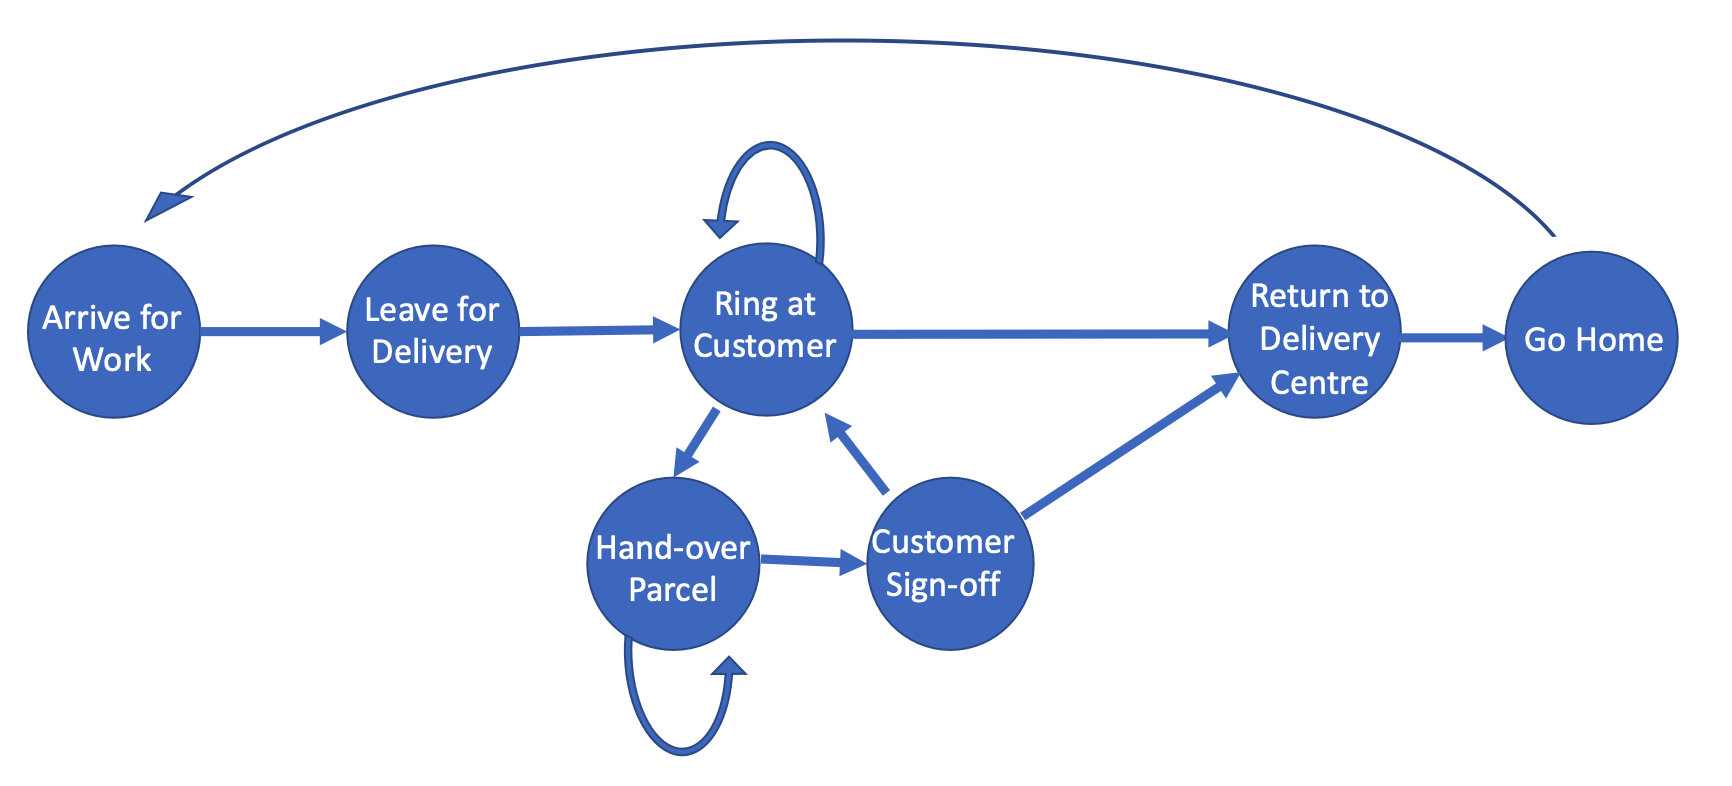

In [35]:
from IPython import display
display.Image("EventGraph Driver.png")

In [36]:
class Driver:
    
    def __init__(self, rec, DC, patience):
        self.rec = rec
        self.DC = DC
        self.patience = patience
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.recordDriverBeginsWork()
        
    def leaveForDelivery(self, tour, parcels):
        for p in parcels:
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL)
            p.outForDelivery()
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " \
                       f"of {len(parcels):d} parcels")
                
    def goHome(self):
        self.location = self.DC.W
        self.parcels = None
        self.returns = None
        self.tour = [ self.DC.W ]
        self.rec.recordDriverEndsWork()
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield from self.leaveForDelivery(tour, parcels)
            self.rec.recordTourLength(pathLength(tour))
            while len(self.parcels)>0:
                # drive to customer
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to "+str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at "+str(cust))
                wait_time = cust.responseTime()
                
                if wait_time<self.patience: 
                    # customer answered door

                    yield self.rec.env.timeout(wait_time)
                    self.rec.trace(str(cust)+" answers door")
                    while len(self.parcels)>0 and \
                            custLocation == self.parcels[0].dest:
                        handover_time = random.expovariate(1/AVERAGE_TIME_HANDOVER)
                        yield self.rec.env.timeout(handover_time)
                        cust.acceptParcel(self.parcels[0])
                        self.parcels = self.parcels[1:]
                    signoff_time = random.expovariate(1/AVERAGE_TIME_SIGNOFF)
                    yield self.rec.env.timeout(signoff_time)
                    self.rec.trace(str(cust)+" signed off")
                else:
                    # customer not at home or to slow
                    yield self.rec.env.timeout(self.patience)
                    self.rec.trace(str(cust)+" doesn't answer the door")
                    while len(self.parcels)>0 and  \
                            custLocation == self.parcels[0].dest:
                        self.returns.append(self.parcels[0])
                        self.parcels = self.parcels[1:]

            # return to delivery centre
            self.rec.trace("Driver returns to delivery centre")
            yield from self.__drive(self.DC.W)
            yield from self.DC.returnFromDelivery(self.returns)
            
            self.rec.recordParcelsLeftOver(len(self.DC.parcels)+
                                           len(self.DC.leftOver))

            self.goHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))


## Class Delivery Centre

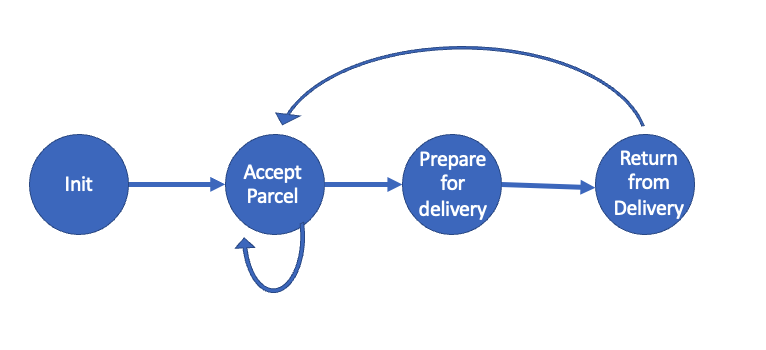

In [37]:
from IPython import display
display.Image("EventGraph Delivery Centre.png")

In [38]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W, limit, heuristic):
        self.rec = rec
        self.M = M
        self.W = W
        self.D, self.P = FW(M)
        self.limit = limit
        self.heuristic = heuristic
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = [W]       # tour planned for delivery
        
    # builds tour incrementally:
    # every single parcel is in the sequence of their
    # acceptance either incorporated into the tour or
    # assigned to left overs 
    def __accept(self, parcel):
        custLoc = parcel.dest
        if custLoc in self.dest:
            self.parcels.append(parcel)
        else:
            if self.heuristic:
                S = createLoopH(self.M, self.D, self.P, [self.W] + self.dest + [custLoc])
            else:
                S = createLoop(self.M, self.D, self.P, [self.W] + self.dest + [custLoc])
            if pathLength(S)<self.limit:
                self.parcels.append(parcel)
                self.dest.append(custLoc)
                self.tour = S
            else:
                self.leftOver.append(parcel)
            
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.rec.recordParcelArrival(parcel)
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        tour = self.tour
        addresses = self.dest
        
        # pick parcels in sequence to be delivered
        for dest in tour:
            if dest in self.dest:
                for p in self.parcels:
                    if p.dest == dest:
                        parcels += [p]
         
        # rearrange the left overs
        L = self.leftOver
        self.tour = [self.W]
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)
        
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, w=tour[0], 
                    grid=True, size=5,
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels
                 
    def returnFromDelivery(self, parcels):
        for p in parcels:
            p.returnFromDelivery()
            yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            self.__accept(p)
        yield self.rec.env.timeout(END_OF_DAY_TIME)

# Simulation

## Parameters

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [39]:
AVERAGE_SPEED = 15/3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [40]:
PREP_TIME_PER_PARCEL = 50

The time to **process returned parcels** in the delivery centre is 30 sec per parcel. 

In [41]:
RETURN_TIME_PER_PARCEL = 30

The average **customer time** to answer the door, accept a parcel, or signoff.

In [42]:
AVERAGE_TIME_ANSWER_DOOR = 40
AVERAGE_TIME_HANDOVER = 10
AVERAGE_TIME_SIGNOFF = 10

The time for end of day closing procedure

In [43]:
END_OF_DAY_TIME = 600

## Simulation Routine

In [44]:
def simulation(M, W, C,      # map geometry
               days,         # run simulation for number of days
               p=0.2,        # parcels per day and customer, 
               limit=30000,  # bike range limit
               q=0.1,        # probability that the customer is not at home 
               patience=60,  # max wait time for customer answering door
               heuristic=False, log=False, plot=False, ticks=False):

    P = generateParcels(days=days, p=p, customers=len(C))
        
    parcels = sum([ len(d) for d in P ])
    
    print(f"Simulating the delivery of {parcels:d} parcels "
          f"over {days:d} days to {len(C):d} customers") 
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, days, parcels, log=log, plot=plot)

    def generatorProcess(env):
                
        DC = DeliveryCentre(rec, M, W, limit, heuristic)
        D = Driver(rec, DC, patience)
        
        # process the parcels day by day
        for CL in P: 
            
            if log:
                print()
            if ticks:
                print(".", end="")

            yield env.timeout(12*3600) # days
            for ci in CL:
                cust = Customer.getCustomer(rec, C[ci], q)
                p = Parcel(rec, cust)
                DC.acceptParcel(p)
            yield env.timeout(12*3600) # days

    env.process(generatorProcess(env))
    env.run()
    
    rec.finish()
    
    return rec

## Model Verification

In [45]:
import pickle
with open('sampleData.pickled', 'rb') as f:
    M, W, C = pickle.load(f)

In [46]:
C

[(7877, 4169),
 (6341, 4279),
 (3326, 7751),
 (3913, 6505),
 (6924, 2845),
 (3677, 5433),
 (6821, 5891),
 (7296, 4962),
 (7397, 3141),
 (3747, 3059)]

In [47]:
W

(8001, 7207)

In [48]:
M

([(2523, 5360),
  (2596, 7555),
  (3349, 3238),
  (4150, 5463),
  (4582, 7057),
  (4761, 3761),
  (5122, 2445),
  (5233, 8264),
  (6171, 6537),
  (6177, 3254),
  (6458, 5010),
  (6832, 9464),
  (7787, 4934),
  (8001, 7207),
  (8005, 3086),
  (7877, 4169),
  (6341, 4279),
  (3326, 7751),
  (3913, 6505),
  (6924, 2845),
  (3677, 5433),
  (6821, 5891),
  (7296, 4962),
  (7397, 3141),
  (3747, 3059)],
 [((2523, 5360), (4761, 3761)),
  ((2523, 5360), (2596, 7555)),
  ((3349, 3238), (2523, 5360)),
  ((4582, 7057), (5233, 8264)),
  ((4761, 3761), (3349, 3238)),
  ((4761, 3761), (4150, 5463)),
  ((4761, 3761), (6458, 5010)),
  ((5122, 2445), (6177, 3254)),
  ((5233, 8264), (6832, 9464)),
  ((6832, 9464), (6171, 6537)),
  ((7787, 4934), (8001, 7207)),
  ((8001, 7207), (6171, 6537)),
  ((8001, 7207), (6832, 9464)),
  ((8005, 3086), (7877, 4169)),
  ((7877, 4169), (7787, 4934)),
  ((6177, 3254), (6341, 4279)),
  ((6341, 4279), (6458, 5010)),
  ((5233, 8264), (3326, 7751)),
  ((3326, 7751), (2596,

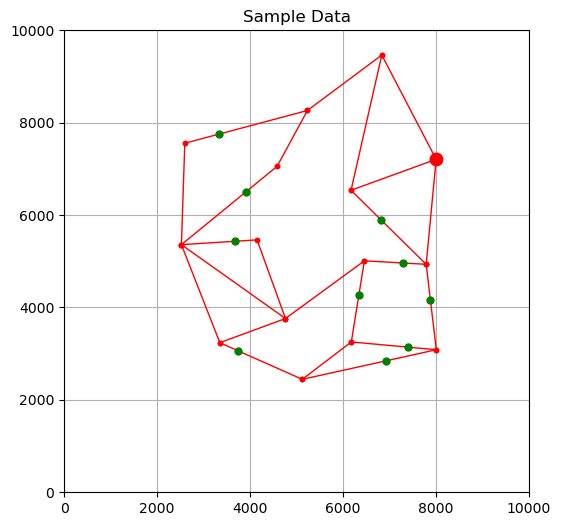

In [49]:
plotMap(M, T=C, w=W, text='Sample Data', grid=True)

Simulating the delivery of 7 parcels over 4 days to 10 customers

[ 0] 18:00:00.0 Driver arrives for work


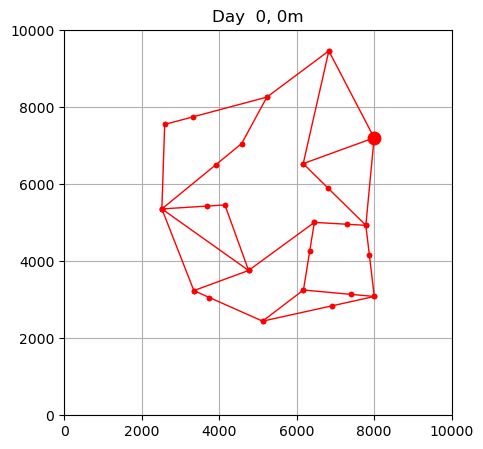

[ 0] 18:00:00.0 Driver leaves for delivery of 0 parcels
[ 0] 18:00:00.0 Driver returns to delivery centre
[ 0] 18:10:00.0 0 left over for next day
[ 0] 18:10:00.0 Driver goes home

[ 1] 12:00:00.0 Parcel:  0 for customer 0 arr at delivery centre
[ 1] 12:00:00.0 Parcel:  0 for customer 0 arrived in delivery centre
[ 1] 18:00:00.0 Driver arrives for work


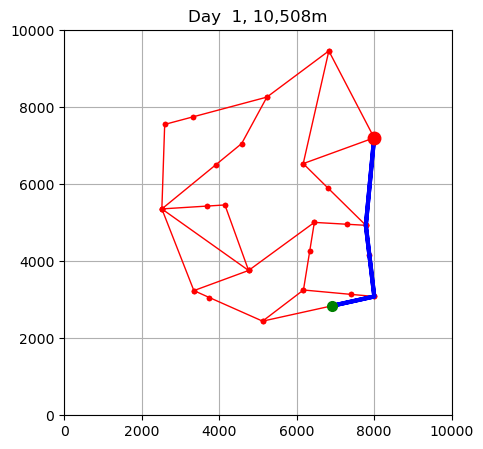

[ 1] 18:00:50.0 Parcel:  0 for customer 0 out for delivery
[ 1] 18:00:50.0 Driver leaves for delivery of 1 parcels
[ 1] 18:00:50.0 Driver drives to Customer:  0 (6924, 2845)
[ 1] 18:21:50.10 Driver arrived at Customer:  0 (6924, 2845)
[ 1] 18:22:50.10 Customer:  0 (6924, 2845) doesn't answer the door
[ 1] 18:22:50.10 Driver returns to delivery centre
[ 1] 18:43:51.9 Parcel:  0 for customer 0 return from delivery
[ 1] 18:54:21.9 1 left over for next day
[ 1] 18:54:21.9 Driver goes home

[ 2] 12:00:00.0 Parcel:  1 for customer 1 arr at delivery centre
[ 2] 12:00:00.0 Parcel:  1 for customer 1 arrived in delivery centre
[ 2] 12:00:00.0 Parcel:  2 for customer 2 arr at delivery centre
[ 2] 12:00:00.0 Parcel:  2 for customer 2 arrived in delivery centre
[ 2] 12:00:00.0 Parcel:  3 for customer 3 arr at delivery centre
[ 2] 12:00:00.0 Parcel:  3 for customer 3 arrived in delivery centre
[ 2] 18:00:00.0 Driver arrives for work


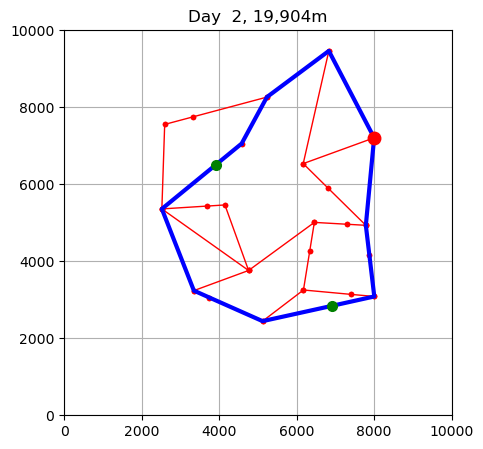

[ 2] 18:00:50.0 Parcel:  0 for customer 0 out for delivery
[ 2] 18:01:40.0 Parcel:  2 for customer 2 out for delivery
[ 2] 18:01:40.0 Driver leaves for delivery of 2 parcels
[ 2] 18:01:40.0 Driver drives to Customer:  0 (6924, 2845)
[ 2] 18:22:40.10 Driver arrived at Customer:  0 (6924, 2845)
[ 2] 18:22:55.8 Customer:  0 (6924, 2845) answers door
[ 2] 18:23:08.9 Parcel:  0 for customer 0 delivered to customer
[ 2] 18:23:31.8 Customer:  0 (6924, 2845) signed off
[ 2] 18:23:31.8 Driver drives to Customer:  2 (3913, 6505)
[ 2] 18:55:00.1 Driver arrived at Customer:  2 (3913, 6505)
[ 2] 18:55:25.7 Customer:  2 (3913, 6505) answers door
[ 2] 18:55:26.7 Parcel:  2 for customer 2 delivered to customer
[ 2] 18:55:32.4 Customer:  2 (3913, 6505) signed off
[ 2] 18:55:32.4 Driver returns to delivery centre
[ 2] 19:32:40.1 2 left over for next day
[ 2] 19:32:40.1 Driver goes home

[ 3] 12:00:00.0 Parcel:  4 for customer 1 arr at delivery centre
[ 3] 12:00:00.0 Parcel:  4 for customer 1 arrived in 

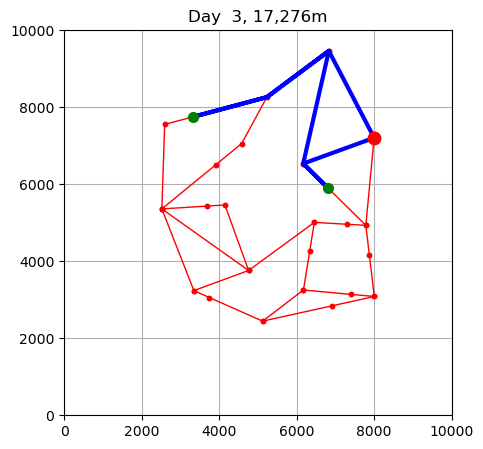

[ 3] 18:00:50.0 Parcel:  1 for customer 1 out for delivery
[ 3] 18:01:40.0 Parcel:  4 for customer 1 out for delivery
[ 3] 18:02:30.0 Parcel:  3 for customer 3 out for delivery
[ 3] 18:02:30.0 Driver leaves for delivery of 3 parcels
[ 3] 18:02:30.0 Driver drives to Customer:  1 (3326, 7751)
[ 3] 18:28:34.1 Driver arrived at Customer:  1 (3326, 7751)
[ 3] 18:29:34.1 Customer:  1 (3326, 7751) doesn't answer the door
[ 3] 18:29:34.1 Driver drives to Customer:  3 (6821, 5891)
[ 3] 19:01:08.4 Driver arrived at Customer:  3 (6821, 5891)
[ 3] 19:01:34.3 Customer:  3 (6821, 5891) answers door
[ 3] 19:01:54.4 Parcel:  3 for customer 3 delivered to customer
[ 3] 19:01:57.4 Customer:  3 (6821, 5891) signed off
[ 3] 19:01:57.4 Driver returns to delivery centre
[ 3] 19:13:25.2 Parcel:  1 for customer 1 return from delivery
[ 3] 19:13:55.2 Parcel:  4 for customer 1 return from delivery
[ 3] 19:24:25.2 4 left over for next day
[ 3] 19:24:25.2 Driver goes home


In [50]:
random.seed(0)
_ = simulation(M, W, C, days=4, p=0.25, limit=20000, log=True, plot=True)

## Run Small Simulation

In [51]:
import pickle
with open('sampleData.pickled', 'rb') as f:
    M, W, C = pickle.load(f)

Simulating the delivery of 20 parcels over 10 days to 10 customers


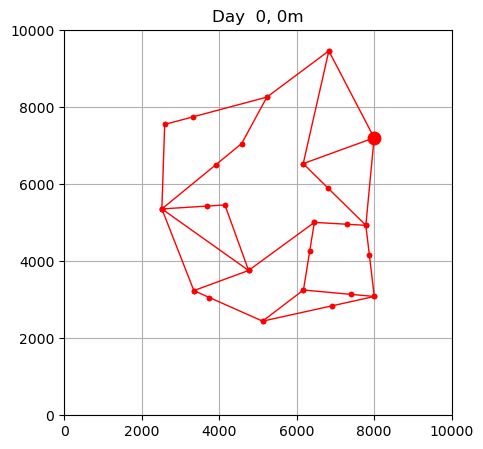

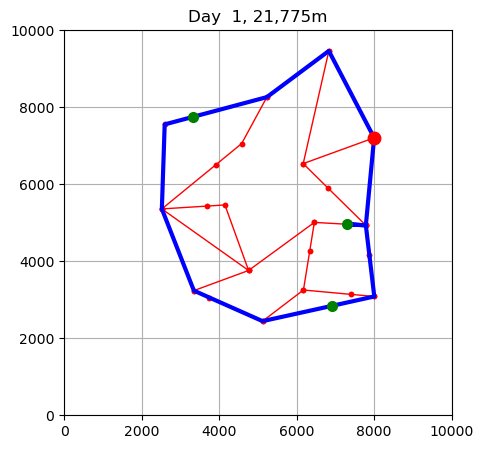

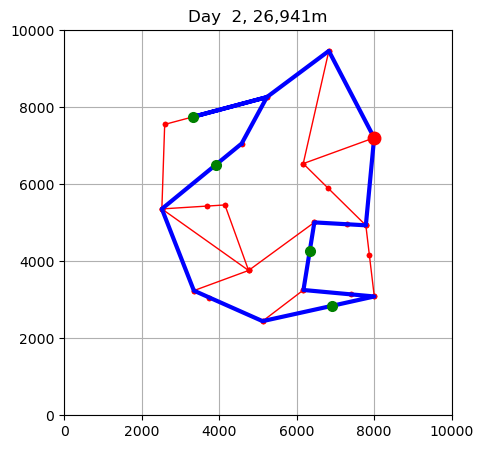

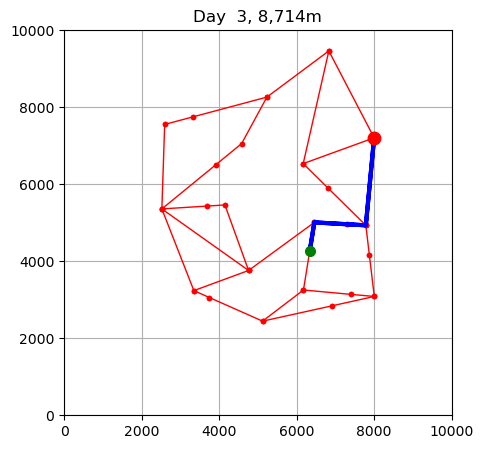

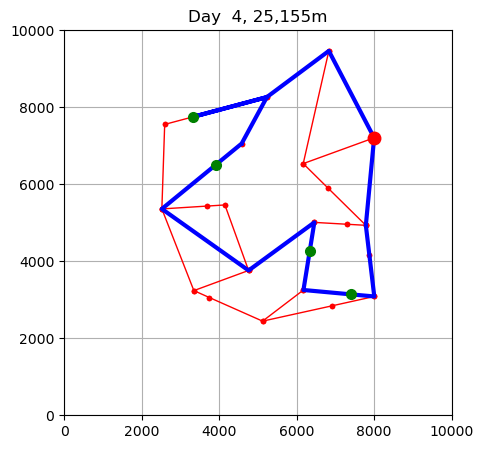

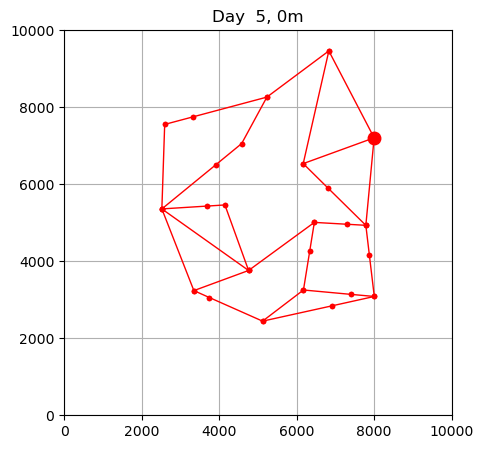

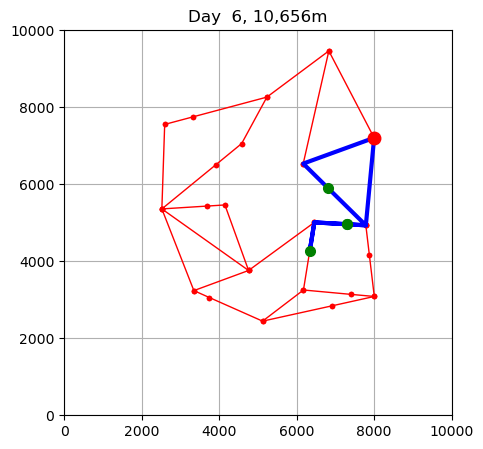

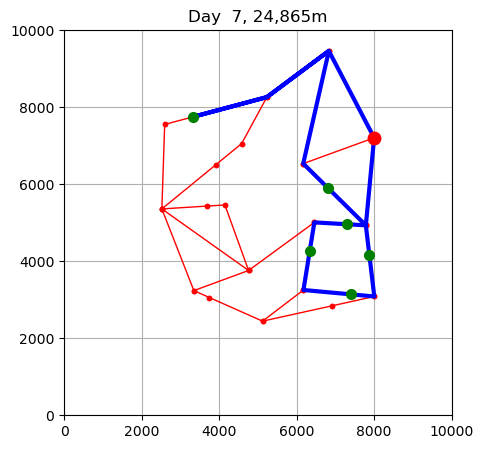

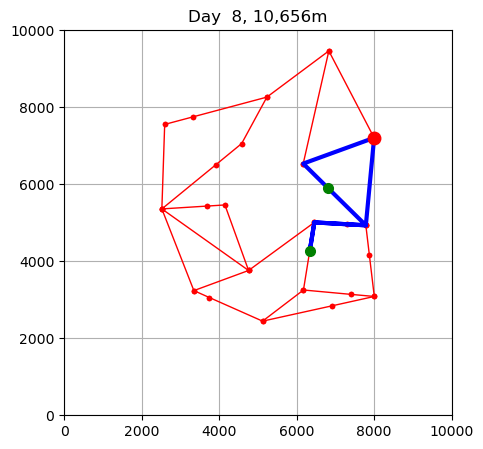

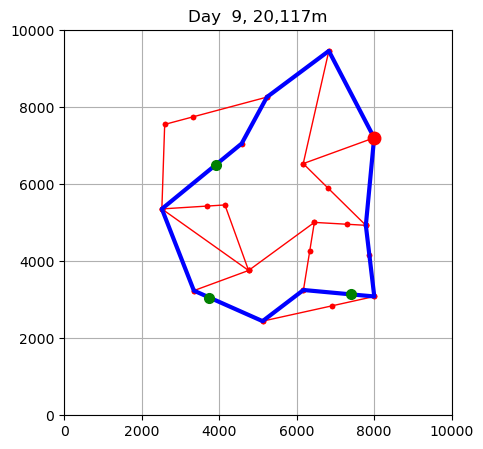

In [52]:
random.seed(0)
rec = simulation(M, W, C, days=10, p=0.25, limit=30000, 
                 heuristic=True, plot=True)

### Analysing Working Time

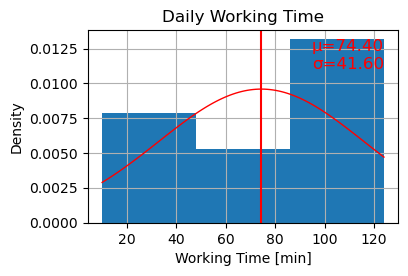

In [53]:
rec.histWorkingTime()

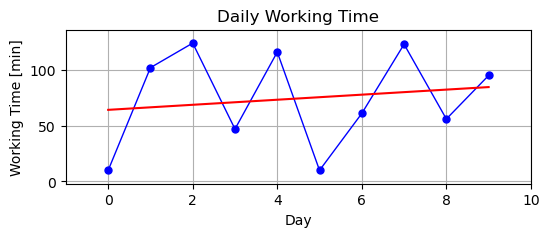

In [54]:
rec.plotWorkingTime()

### Analyse Tour Length

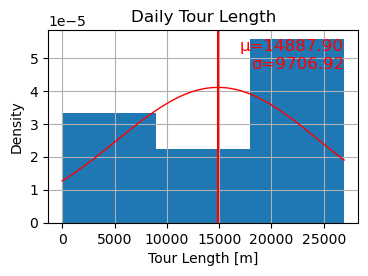

In [55]:
rec.histTourLength()

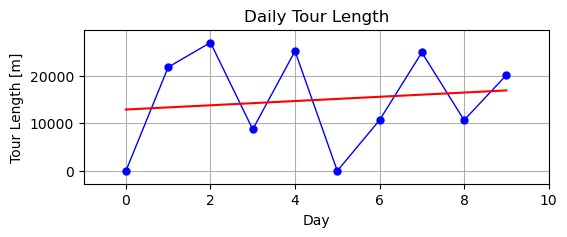

In [56]:
rec.plotTourLength()

### Analyse Number of Left-Over Parcels

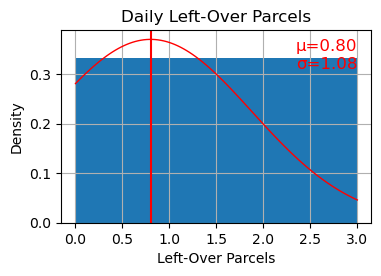

In [57]:
rec.histLeftOver()

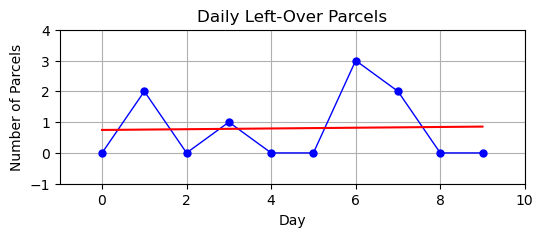

In [58]:
rec.plotLeftOver()

### Analyse Delayed Parcel Delivery

In [59]:
rec.tableParcelDelay()

Delivery Delay (20 parcels)
   None:     14   70.0%
 1 days:      4   20.0%
 2 days:      2   10.0%


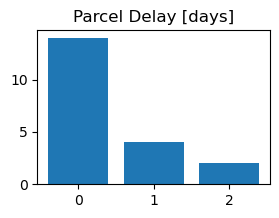

In [60]:
rec.barplotParcelDelay()

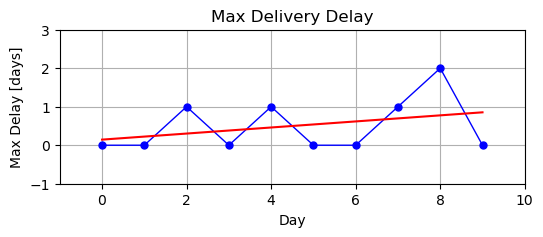

In [61]:
rec.plotParcelDelay()

## Run Multiple Larger Simulation

In [62]:
def multiSimulation(seeds,        # seed values for simulation runs   
                    M, W, C,      # Geometry data
                    days=50,      # run simulation for number of days
                    p=0.2,        # parcels per day and customer, 
                    limit=30000,  # bike range limit
                    q=0.1,        # probability that the customer is not at home 
                    patience=60): # max wait time for customer answering door
    for seed in seeds:
        random.seed(seed)
        filename = f"rec days={days:d} p={p:2.2f} limit={limit:d} " + \
                   f"q={q:2.2f} patience={patience:d} seed={seed:d}"
        print(filename)
        rec = simulation(M, W, C, 
                         days=days, p=p, limit=limit, q=q, patience=patience, 
                         heuristic=True, ticks=True)
        with open('res/'+filename, 'wb') as f:
            pickle.dump(rec, f)
        print()

In [63]:
def loadSimulations(seeds,        # seed values for simulation runs   
                    days=50,      # run simulation for number of days
                    p=0.2,        # parcels per day and customer, 
                    limit=30000,  # bike range limit
                    q=0.1,        # probability that the customer is not at home 
                    patience=60): # max wait time for customer answering door
    recs = []
    for seed in seeds:
        random.seed(seed)
        filename = f"rec days={days:d} p={p:2.2f} limit={limit:d} " + \
                   f"q={q:2.2f} patience={patience:d} seed={seed:d}"
        print(filename)
        with open('res/'+filename, 'rb') as f:
            rec = pickle.load(f)
            recs.append(rec)
    return recs

### Run Simulations

In [64]:
import pickle
with open('sampleData.pickled', 'rb') as f:
    M, W, C = pickle.load(f)

In [65]:
multiSimulation(range(10), M, W, C, limit=30000, days=50)


rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=0
Simulating the delivery of 84 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=1
Simulating the delivery of 108 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=2
Simulating the delivery of 85 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=3
Simulating the delivery of 81 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=4
Simulating the delivery of 106 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=5
Simulating the delivery of 91 parcels over 50 days to 10 customers

# Combine Simulation 

In [66]:
recs = loadSimulations(range(10), limit=30000, days=50)

rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=0
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=1
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=2
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=3
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=4
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=5
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=6
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=7
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=8
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=9


In [67]:
rec = combineRecorders(recs)

### Analysis

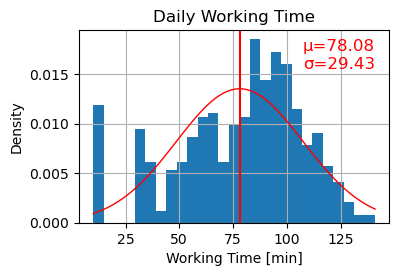

In [68]:
rec.histWorkingTime()

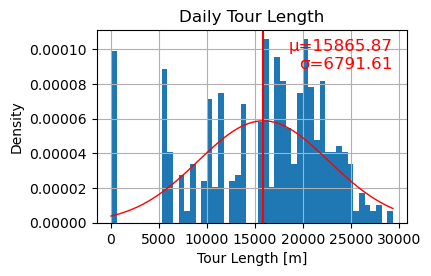

In [69]:
rec.histTourLength()

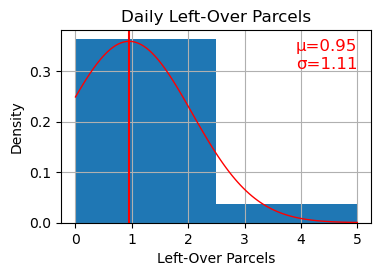

In [70]:
rec.histLeftOver()

In [71]:
rec.tableParcelDelay()

Delivery Delay (979 parcels)
   None:    658   67.2%
 1 days:    220   22.5%
 2 days:     66    6.7%
 3 days:     23    2.3%
 4 days:     10    1.0%
 5 days:      0    0.0%
 6 days:      1    0.1%
 7 days:      1    0.1%


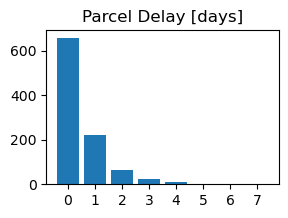

In [72]:
rec.barplotParcelDelay()

# Trying simulation for a 35km bike

In [73]:
multiSimulation(range(10), M, W, C, limit=35000, days=50)


rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=0
Simulating the delivery of 84 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=1
Simulating the delivery of 108 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=2
Simulating the delivery of 85 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=3
Simulating the delivery of 81 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=4
Simulating the delivery of 106 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=5
Simulating the delivery of 91 parcels over 50 days to 10 customers

In [74]:
recs = loadSimulations(range(10), limit=35000, days=50)

rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=0
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=1
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=2
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=3
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=4
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=5
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=6
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=7
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=8
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=9


In [75]:
rec = combineRecorders(recs)

In [76]:
rec.tableParcelDelay()

Delivery Delay (979 parcels)
   None:    660   67.4%
 1 days:    219   22.4%
 2 days:     65    6.6%
 3 days:     23    2.3%
 4 days:     10    1.0%
 5 days:      0    0.0%
 6 days:      1    0.1%
 7 days:      1    0.1%


# Test for a 45km bike

In [77]:
multiSimulation(range(10), M, W, C, limit=45000, days=50)


rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=0
Simulating the delivery of 84 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=1
Simulating the delivery of 108 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=2
Simulating the delivery of 85 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=3
Simulating the delivery of 81 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=4
Simulating the delivery of 106 parcels over 50 days to 10 customers
..................................................
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=5
Simulating the delivery of 91 parcels over 50 days to 10 customers

In [78]:
recs = loadSimulations(range(10), limit=45000, days=50)

rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=0
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=1
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=2
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=3
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=4
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=5
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=6
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=7
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=8
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=9


In [79]:
rec = combineRecorders(recs)

In [80]:
rec.tableParcelDelay()

Delivery Delay (979 parcels)
   None:    660   67.4%
 1 days:    219   22.4%
 2 days:     65    6.6%
 3 days:     23    2.3%
 4 days:     10    1.0%
 5 days:      0    0.0%
 6 days:      1    0.1%
 7 days:      1    0.1%


# Moving on to run simulations for actual data

In [81]:
import pickle
with open('data.pickled', 'rb') as f:
    M, W, C = pickle.load(f)

# Analysis - (0.20, 30km)

In [82]:
multiSimulation(range(10), M, W, C)

rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=0
Simulating the delivery of 985 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=1
Simulating the delivery of 993 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=2
Simulating the delivery of 979 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=3
Simulating the delivery of 993 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=4
Simulating the delivery of 982 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=5
Simulating the delivery of 1020 parcels over 50 days to 10

In [83]:
recs = loadSimulations(range(10))

rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=0
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=1
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=2
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=3
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=4
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=5
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=6
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=7
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=8
rec days=50 p=0.20 limit=30000 q=0.10 patience=60 seed=9


In [84]:
rec = combineRecorders(recs)

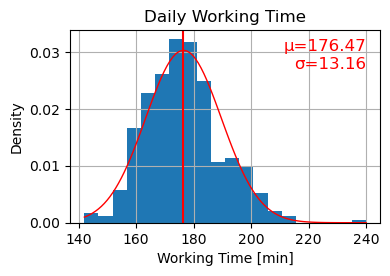

In [85]:
rec.histWorkingTime()

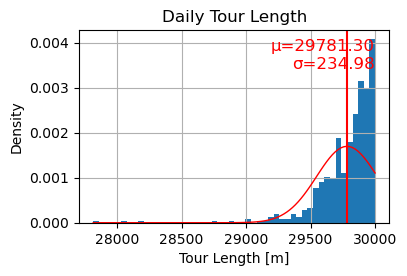

In [86]:
rec.histTourLength()

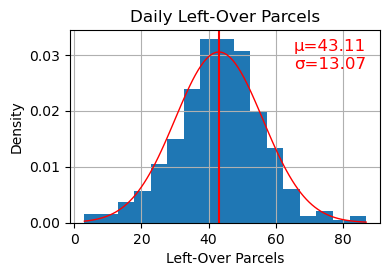

In [87]:
rec.histLeftOver()

In [88]:
rec.tableParcelDelay()

Delivery Delay (9998 parcels)
   None:   2101   21.0%
 1 days:   2364   23.6%
 2 days:   2627   26.3%
 3 days:   1082   10.8%
 4 days:    646    6.5%
 5 days:    470    4.7%
 6 days:    296    3.0%
 7 days:    172    1.7%
 8 days:    107    1.1%
 9 days:     46    0.5%
10 days:     25    0.3%
11 days:     27    0.3%
12 days:     11    0.1%
13 days:      5    0.1%
14 days:     11    0.1%
15 days:      3    0.0%
16 days:      2    0.0%
17 days:      2    0.0%
18 days:      1    0.0%


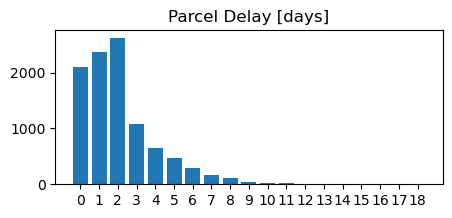

In [89]:
rec.barplotParcelDelay()

# Analysis - (0.24, 30km)

In [90]:
multiSimulation(range(10), M, W, C, p = 0.24)


rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=0
Simulating the delivery of 1216 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=1
Simulating the delivery of 1159 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=2
Simulating the delivery of 1173 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=3
Simulating the delivery of 1203 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=4
Simulating the delivery of 1144 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=5
Simulating the delivery of 1263 parcels over 50 days 

In [91]:
recs = loadSimulations(range(10), p = 0.24)

rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=0
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=1
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=2
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=3
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=4
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=5
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=6
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=7
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=8
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=9


In [92]:
rec = combineRecorders(recs)

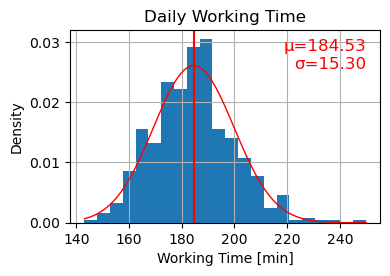

In [93]:
rec.histWorkingTime()

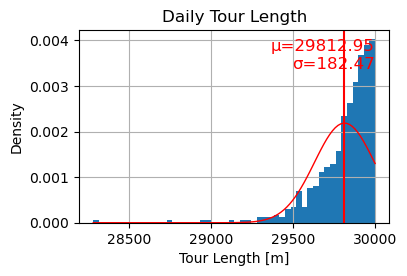

In [94]:
rec.histTourLength()

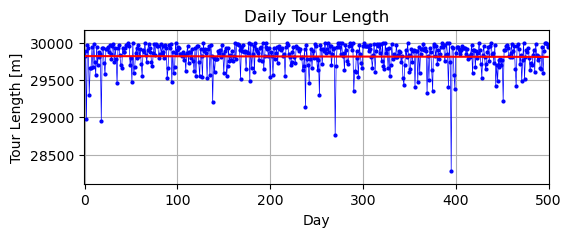

In [95]:
rec.plotTourLength()

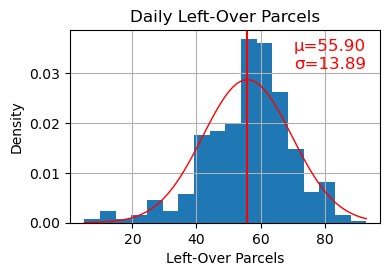

In [96]:
rec.histLeftOver()

In [97]:
rec.tableParcelDelay()

Delivery Delay (11963 parcels)
   None:   2557   21.4%
 1 days:   2550   21.3%
 2 days:   2895   24.2%
 3 days:   1592   13.3%
 4 days:    659    5.5%
 5 days:    634    5.3%
 6 days:    433    3.6%
 7 days:    202    1.7%
 8 days:    154    1.3%
 9 days:    100    0.8%
10 days:     60    0.5%
11 days:     45    0.4%
12 days:     30    0.3%
13 days:     21    0.2%
14 days:     16    0.1%
15 days:      4    0.0%
16 days:      4    0.0%
17 days:      3    0.0%
18 days:      1    0.0%
19 days:      0    0.0%
20 days:      2    0.0%
21 days:      0    0.0%
22 days:      0    0.0%
23 days:      0    0.0%
24 days:      1    0.0%


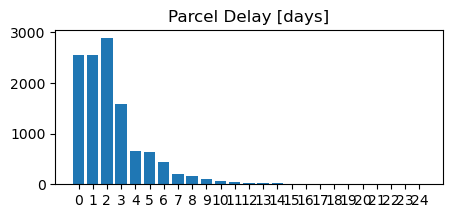

In [98]:
rec.barplotParcelDelay()

# Combining process for other 30km bike simulations

In [99]:
multiSimulation(range(10), M, W, C, p = 0.24)
multiSimulation(range(10), M, W, C, p = 0.28)
multiSimulation(range(10), M, W, C, p = 0.35)

rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=0
Simulating the delivery of 1216 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=1
Simulating the delivery of 1159 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=2
Simulating the delivery of 1173 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=3
Simulating the delivery of 1203 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=4
Simulating the delivery of 1144 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=5
Simulating the delivery of 1263 parcels over 50 days 

In [100]:
recs1 = loadSimulations(range(10), p = 0.24)
recs2 = loadSimulations(range(10), p = 0.28)
recs3 = loadSimulations(range(10), p = 0.35)

rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=0
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=1
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=2
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=3
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=4
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=5
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=6
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=7
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=8
rec days=50 p=0.24 limit=30000 q=0.10 patience=60 seed=9
rec days=50 p=0.28 limit=30000 q=0.10 patience=60 seed=0
rec days=50 p=0.28 limit=30000 q=0.10 patience=60 seed=1
rec days=50 p=0.28 limit=30000 q=0.10 patience=60 seed=2
rec days=50 p=0.28 limit=30000 q=0.10 patience=60 seed=3
rec days=50 p=0.28 limit=30000 q=0.10 patience=60 seed=4
rec days=50 p=0.28 limit=30000 q=0.10 patience=60 seed=5
rec days=50 p=0.28 limit=30000 q=0.10 patience=60 seed=6
rec days=50 p=0.28 limit=30000 

In [101]:
rec1 = combineRecorders(recs1)
rec2 = combineRecorders(recs2)
rec3 = combineRecorders(recs3)

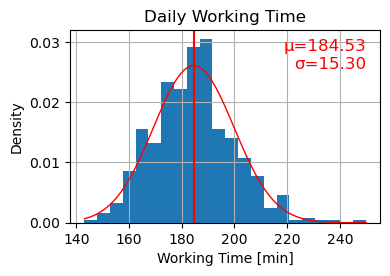

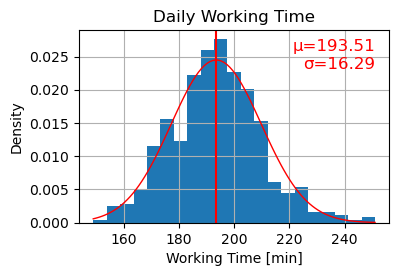

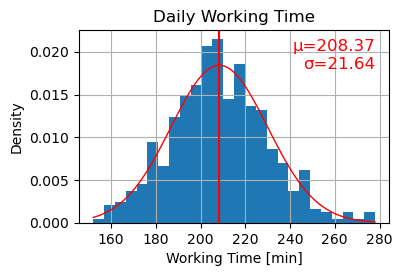

In [102]:
rec1.histWorkingTime()
rec2.histWorkingTime()
rec3.histWorkingTime()

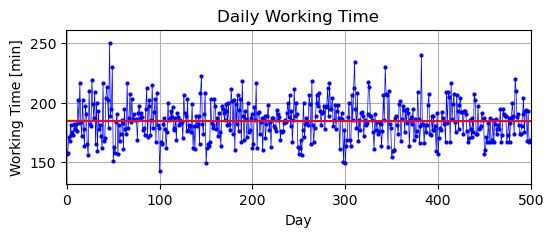

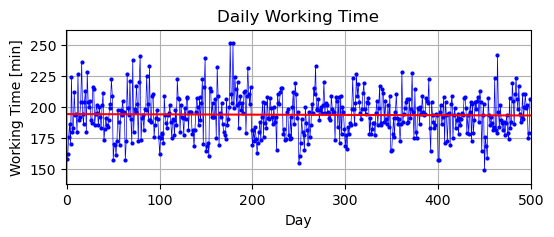

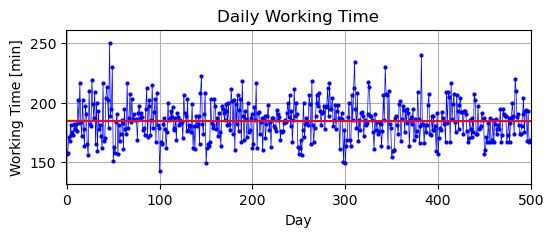

In [103]:
rec1.plotWorkingTime()
rec2.plotWorkingTime()
rec1.plotWorkingTime()

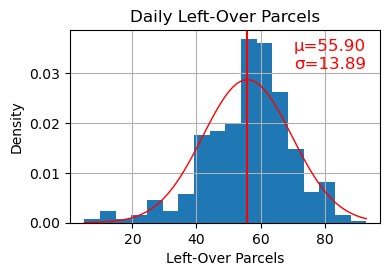

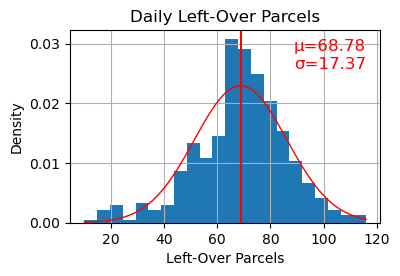

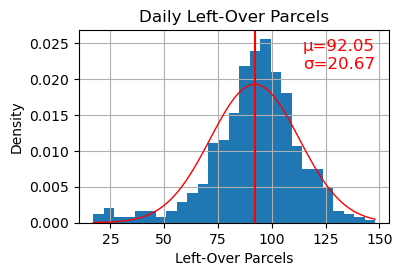

In [104]:
rec1.histLeftOver()
rec2.histLeftOver()
rec3.histLeftOver()

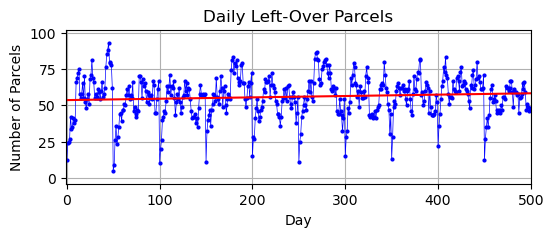

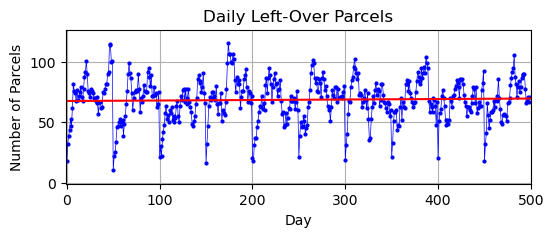

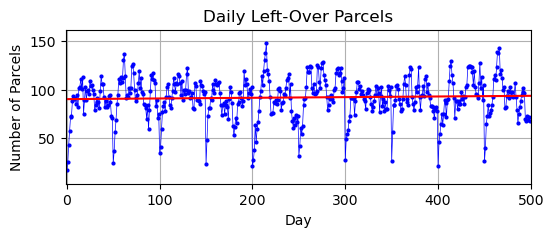

In [105]:
rec1.plotLeftOver()
rec2.plotLeftOver()
rec3.plotLeftOver()

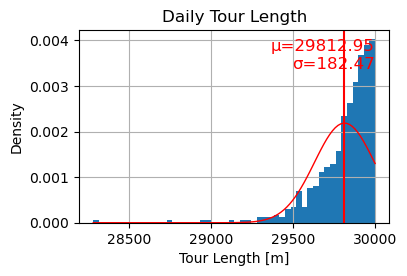

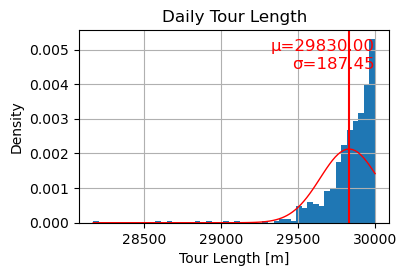

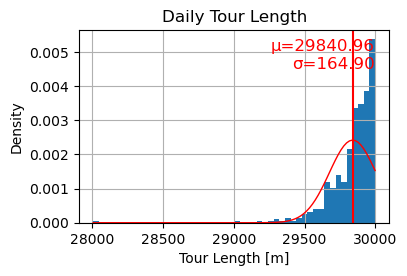

In [106]:
rec1.histTourLength()
rec2.histTourLength()
rec3.histTourLength()

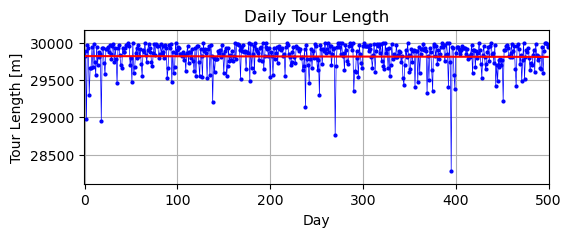

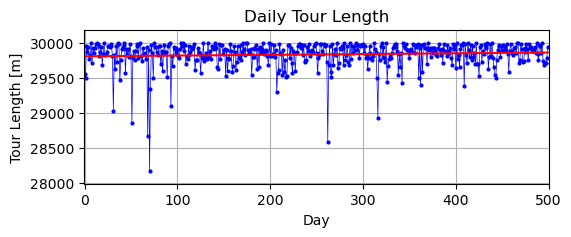

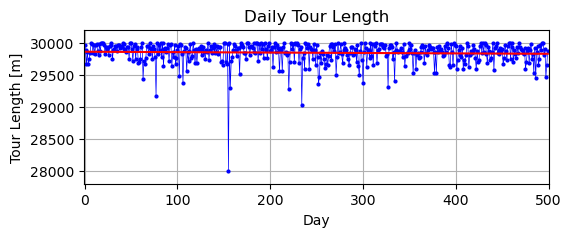

In [107]:
rec1.plotTourLength()
rec2.plotTourLength()
rec3.plotTourLength()

In [108]:
rec1.tableParcelDelay()
rec2.tableParcelDelay()
rec3.tableParcelDelay()

Delivery Delay (11963 parcels)
   None:   2557   21.4%
 1 days:   2550   21.3%
 2 days:   2895   24.2%
 3 days:   1592   13.3%
 4 days:    659    5.5%
 5 days:    634    5.3%
 6 days:    433    3.6%
 7 days:    202    1.7%
 8 days:    154    1.3%
 9 days:    100    0.8%
10 days:     60    0.5%
11 days:     45    0.4%
12 days:     30    0.3%
13 days:     21    0.2%
14 days:     16    0.1%
15 days:      4    0.0%
16 days:      4    0.0%
17 days:      3    0.0%
18 days:      1    0.0%
19 days:      0    0.0%
20 days:      2    0.0%
21 days:      0    0.0%
22 days:      0    0.0%
23 days:      0    0.0%
24 days:      1    0.0%
Delivery Delay (14019 parcels)
   None:   2940   21.0%
 1 days:   2884   20.6%
 2 days:   3086   22.0%
 3 days:   2121   15.1%
 4 days:    869    6.2%
 5 days:    711    5.1%
 6 days:    496    3.5%
 7 days:    293    2.1%
 8 days:    198    1.4%
 9 days:    141    1.0%
10 days:     92    0.7%
11 days:     57    0.4%
12 days:     37    0.3%
13 days:     22    0.2%
14

# Running simulations for 35km bike at 4 different p values (0.2,0.24,0.28,0.35)

In [109]:
multiSimulation(range(10), M, W, C, p = 0.20, limit = 35000)
multiSimulation(range(10), M, W, C, p = 0.24, limit = 35000)
multiSimulation(range(10), M, W, C, p = 0.28, limit = 35000)
multiSimulation(range(10), M, W, C, p = 0.35, limit = 35000)

rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=0
Simulating the delivery of 985 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=1
Simulating the delivery of 993 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=2
Simulating the delivery of 979 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=3
Simulating the delivery of 993 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=4
Simulating the delivery of 982 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=5
Simulating the delivery of 1020 parcels over 50 days to 10

In [110]:
recs4 = loadSimulations(range(10), p = 0.20, limit = 35000)
recs5 = loadSimulations(range(10), p = 0.24, limit = 35000)
recs6 = loadSimulations(range(10), p = 0.28, limit = 35000)
recs7 = loadSimulations(range(10), p = 0.35, limit = 35000)

rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=0
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=1
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=2
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=3
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=4
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=5
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=6
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=7
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=8
rec days=50 p=0.20 limit=35000 q=0.10 patience=60 seed=9
rec days=50 p=0.24 limit=35000 q=0.10 patience=60 seed=0
rec days=50 p=0.24 limit=35000 q=0.10 patience=60 seed=1
rec days=50 p=0.24 limit=35000 q=0.10 patience=60 seed=2
rec days=50 p=0.24 limit=35000 q=0.10 patience=60 seed=3
rec days=50 p=0.24 limit=35000 q=0.10 patience=60 seed=4
rec days=50 p=0.24 limit=35000 q=0.10 patience=60 seed=5
rec days=50 p=0.24 limit=35000 q=0.10 patience=60 seed=6
rec days=50 p=0.24 limit=35000 

In [111]:
rec4 = combineRecorders(recs4)
rec5 = combineRecorders(recs5)
rec6 = combineRecorders(recs6)
rec7 = combineRecorders(recs7)

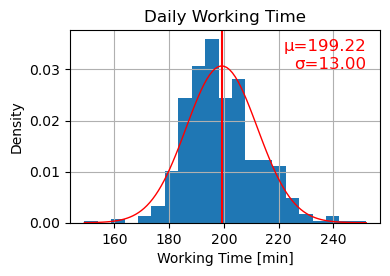

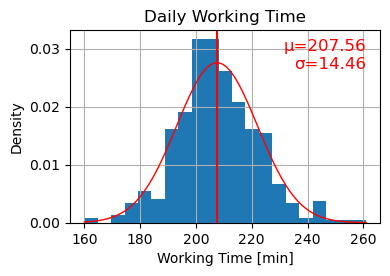

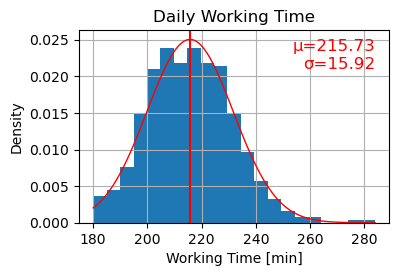

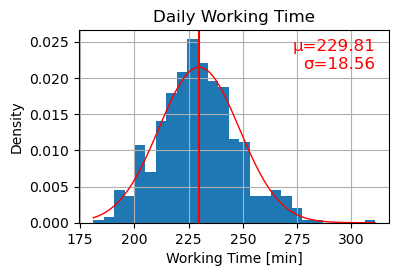

In [112]:
rec4.histWorkingTime()
rec5.histWorkingTime()
rec6.histWorkingTime()
rec7.histWorkingTime()

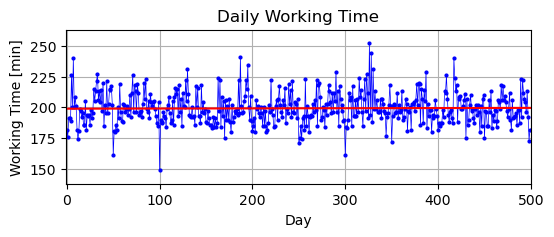

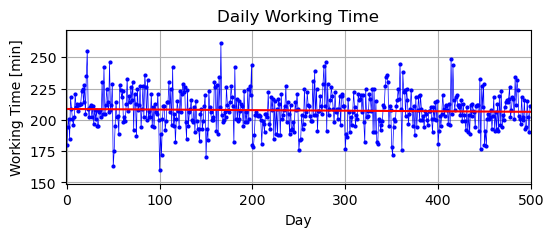

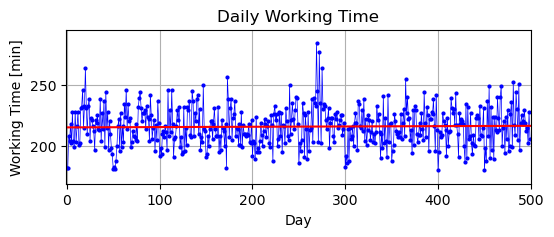

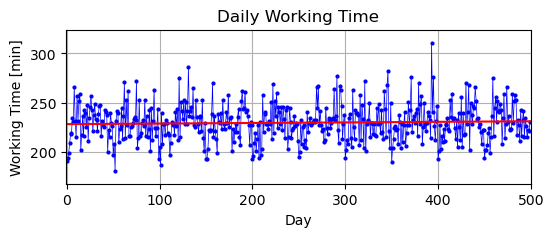

In [113]:
rec4.plotWorkingTime()
rec5.plotWorkingTime()  
rec6.plotWorkingTime()
rec7.plotWorkingTime()

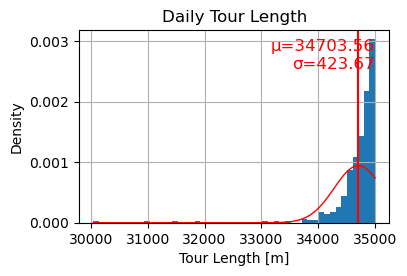

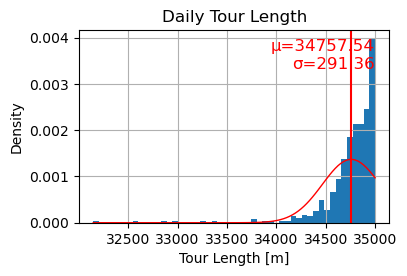

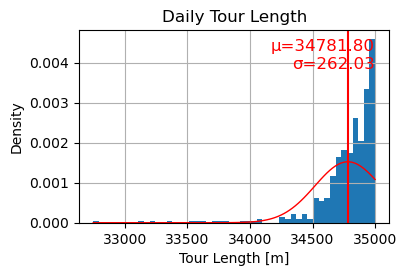

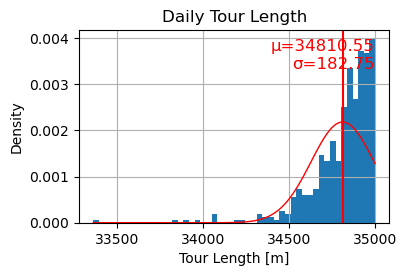

In [114]:
rec4.histTourLength()
rec5.histTourLength()
rec6.histTourLength()
rec7.histTourLength()

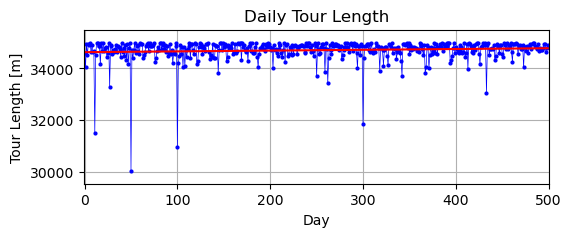

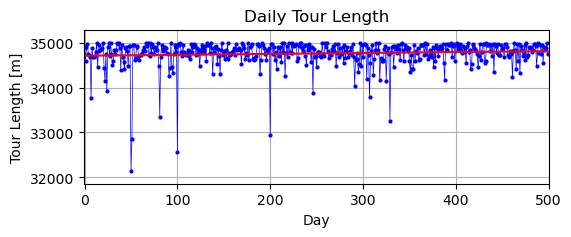

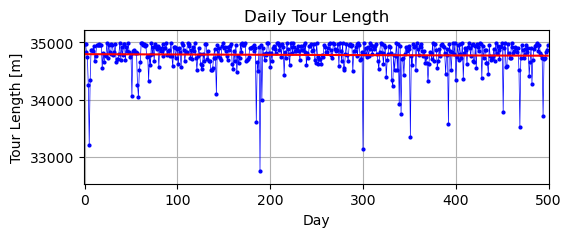

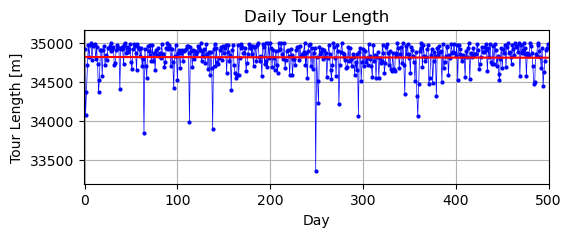

In [115]:
rec4.plotTourLength()
rec5.plotTourLength()
rec6.plotTourLength()
rec7.plotTourLength()

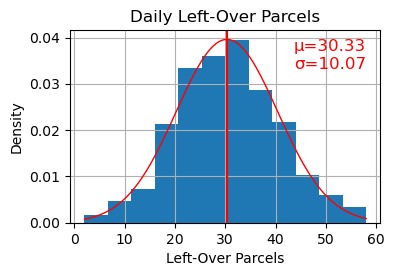

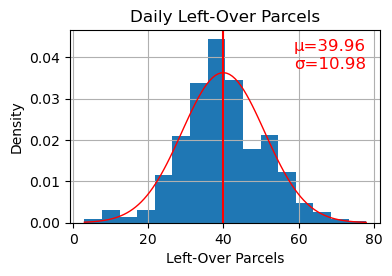

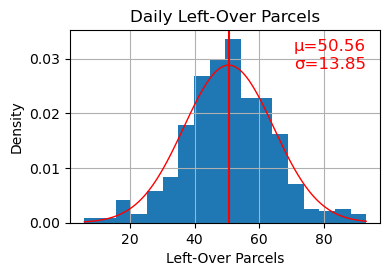

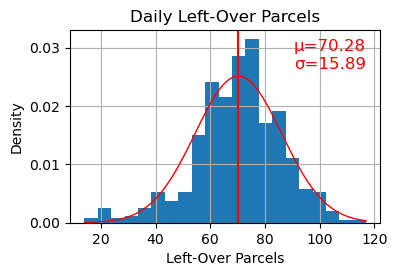

In [116]:
rec4.histLeftOver()
rec5.histLeftOver()
rec6.histLeftOver()
rec7.histLeftOver()

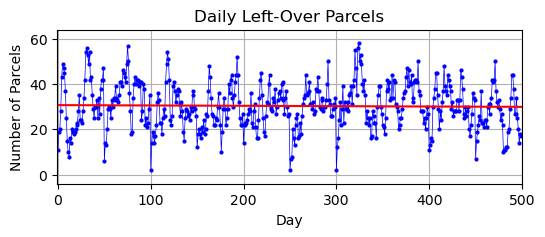

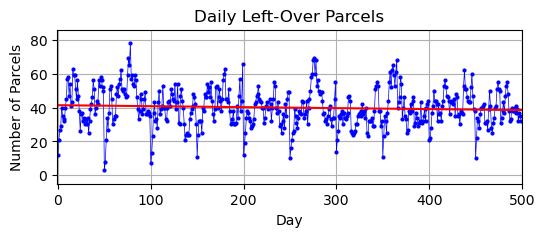

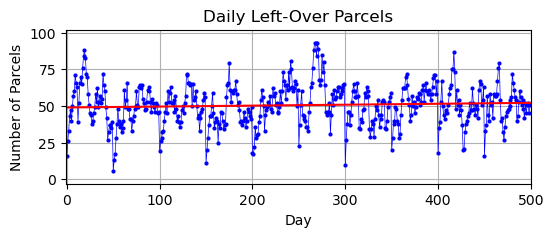

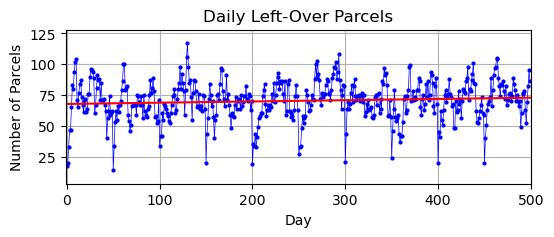

In [117]:
rec4.plotLeftOver()
rec5.plotLeftOver()
rec6.plotLeftOver()
rec7.plotLeftOver()

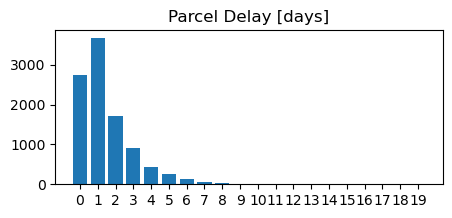

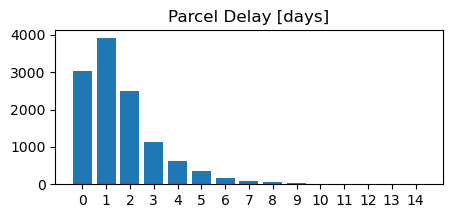

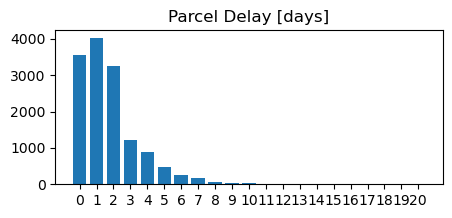

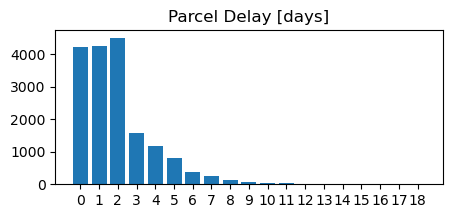

In [118]:
rec4.barplotParcelDelay()
rec5.barplotParcelDelay()
rec6.barplotParcelDelay()
rec7.barplotParcelDelay()

In [119]:
rec4.tableParcelDelay()
rec5.tableParcelDelay()
rec6.tableParcelDelay()
rec7.tableParcelDelay()

Delivery Delay (9998 parcels)
   None:   2743   27.4%
 1 days:   3678   36.8%
 2 days:   1713   17.1%
 3 days:    910    9.1%
 4 days:    429    4.3%
 5 days:    265    2.7%
 6 days:    120    1.2%
 7 days:     62    0.6%
 8 days:     34    0.3%
 9 days:     18    0.2%
10 days:     14    0.1%
11 days:      4    0.0%
12 days:      3    0.0%
13 days:      1    0.0%
14 days:      2    0.0%
15 days:      1    0.0%
16 days:      0    0.0%
17 days:      0    0.0%
18 days:      0    0.0%
19 days:      1    0.0%
Delivery Delay (11963 parcels)
   None:   3042   25.4%
 1 days:   3926   32.8%
 2 days:   2496   20.9%
 3 days:   1138    9.5%
 4 days:    610    5.1%
 5 days:    358    3.0%
 6 days:    176    1.5%
 7 days:     95    0.8%
 8 days:     68    0.6%
 9 days:     25    0.2%
10 days:     17    0.1%
11 days:      6    0.1%
12 days:      2    0.0%
13 days:      3    0.0%
14 days:      1    0.0%
Delivery Delay (14019 parcels)
   None:   3553   25.3%
 1 days:   4036   28.8%
 2 days:   3263   23

# Running simulations for 40km bike at 4 different p values (0.2,0.24,0.28,0.35)


In [120]:
multiSimulation(range(10), M, W, C, p = 0.20, limit = 40000)
multiSimulation(range(10), M, W, C, p = 0.24, limit = 40000)
multiSimulation(range(10), M, W, C, p = 0.28, limit = 40000)
multiSimulation(range(10), M, W, C, p = 0.35, limit = 40000)

rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=0
Simulating the delivery of 985 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=1
Simulating the delivery of 993 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=2
Simulating the delivery of 979 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=3
Simulating the delivery of 993 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=4
Simulating the delivery of 982 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=5
Simulating the delivery of 1020 parcels over 50 days to 10

In [121]:
recs8 = loadSimulations(range(10), p = 0.20, limit = 40000)
recs9 = loadSimulations(range(10), p = 0.24, limit = 40000)
recs10 = loadSimulations(range(10), p = 0.28, limit = 40000)
recs11 = loadSimulations(range(10), p = 0.35, limit = 40000)

rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=0
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=1
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=2
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=3
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=4
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=5
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=6
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=7
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=8
rec days=50 p=0.20 limit=40000 q=0.10 patience=60 seed=9
rec days=50 p=0.24 limit=40000 q=0.10 patience=60 seed=0
rec days=50 p=0.24 limit=40000 q=0.10 patience=60 seed=1
rec days=50 p=0.24 limit=40000 q=0.10 patience=60 seed=2
rec days=50 p=0.24 limit=40000 q=0.10 patience=60 seed=3
rec days=50 p=0.24 limit=40000 q=0.10 patience=60 seed=4
rec days=50 p=0.24 limit=40000 q=0.10 patience=60 seed=5
rec days=50 p=0.24 limit=40000 q=0.10 patience=60 seed=6
rec days=50 p=0.24 limit=40000 

In [122]:
rec8 = combineRecorders(recs8)
rec9 = combineRecorders(recs9)
rec10 = combineRecorders(recs10)
rec11 = combineRecorders(recs11)

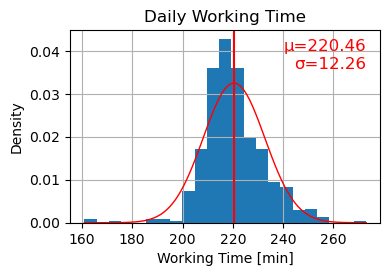

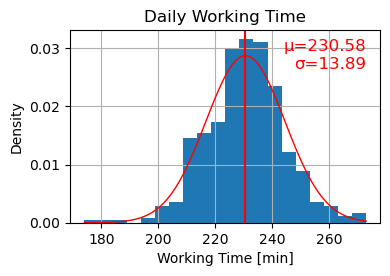

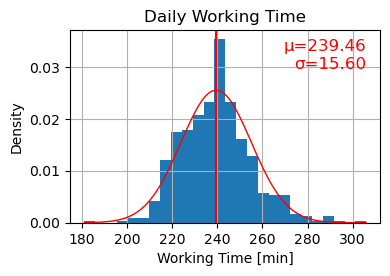

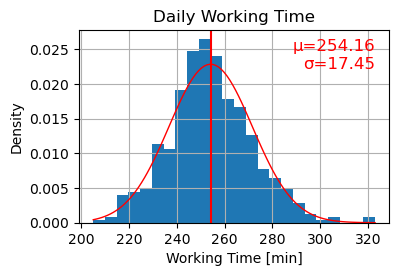

In [123]:
rec8.histWorkingTime()
rec9.histWorkingTime()
rec10.histWorkingTime()
rec11.histWorkingTime()

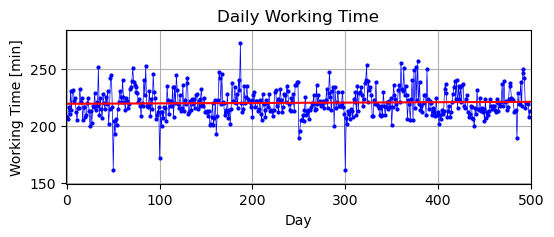

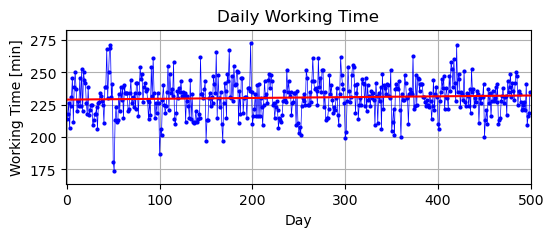

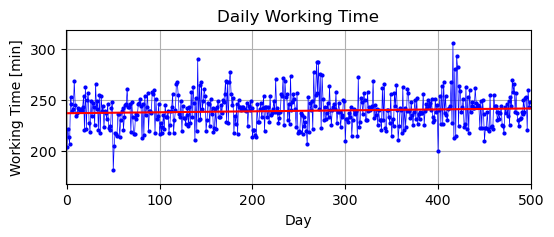

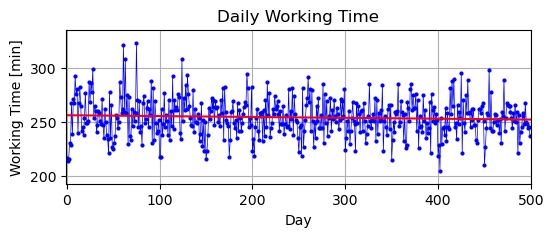

In [124]:
rec8.plotWorkingTime()
rec9.plotWorkingTime()
rec10.plotWorkingTime()
rec11.plotWorkingTime()

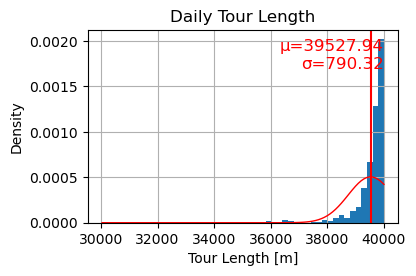

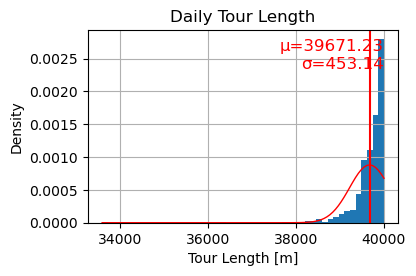

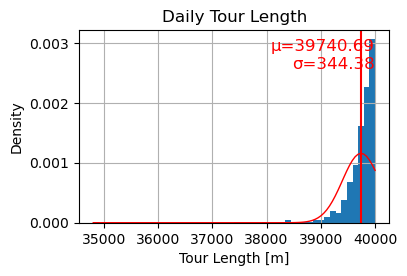

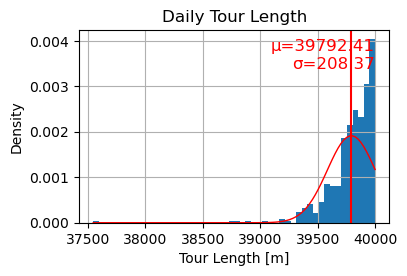

In [125]:
rec8.histTourLength()
rec9.histTourLength()
rec10.histTourLength()
rec11.histTourLength()

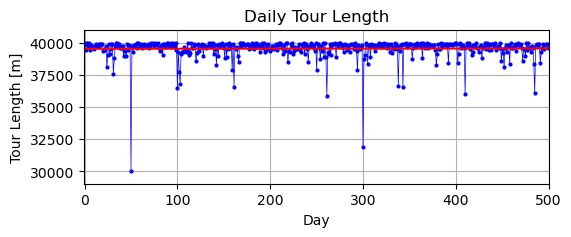

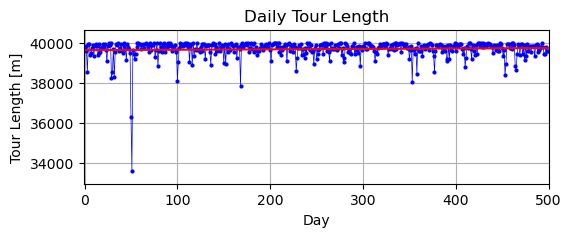

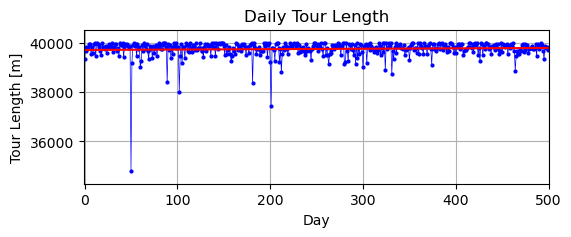

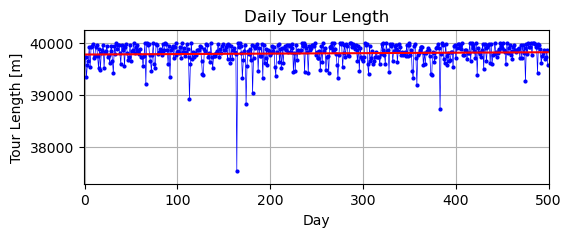

In [126]:
rec8.plotTourLength()
rec9.plotTourLength()
rec10.plotTourLength()
rec11.plotTourLength()

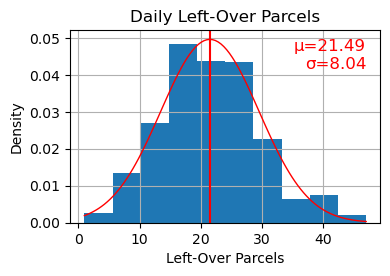

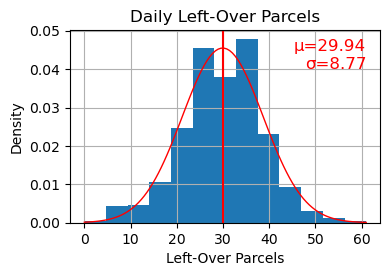

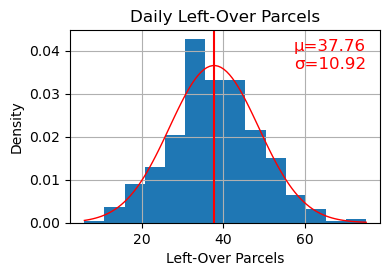

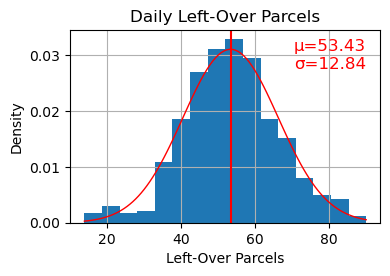

In [127]:
rec8.histLeftOver()
rec9.histLeftOver()
rec10.histLeftOver()
rec11.histLeftOver()

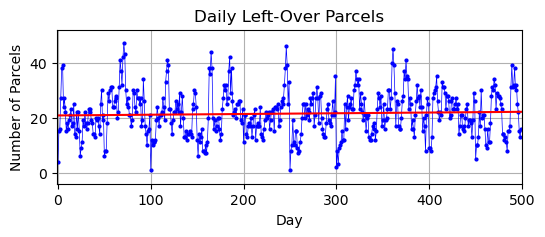

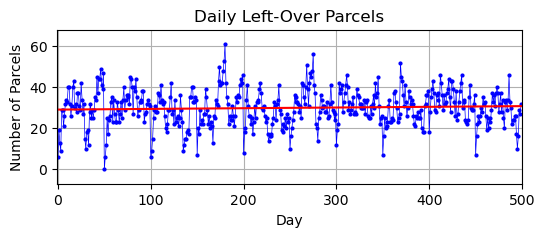

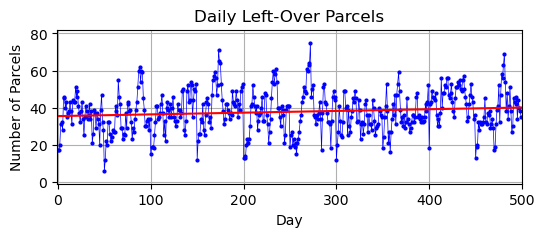

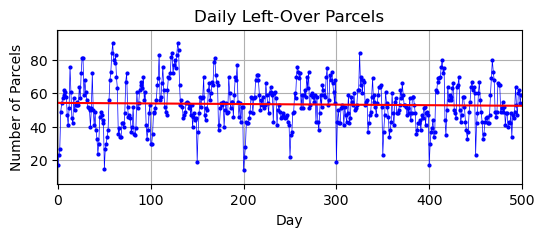

In [128]:
rec8.plotLeftOver()
rec9.plotLeftOver()
rec10.plotLeftOver()
rec11.plotLeftOver()

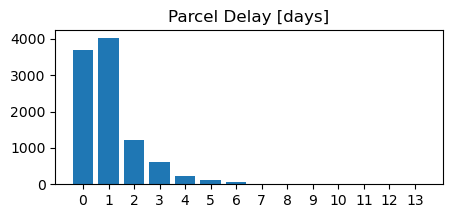

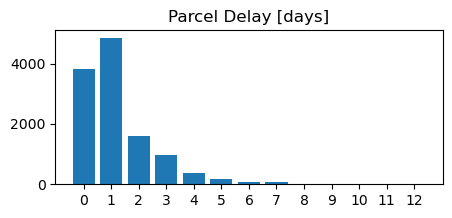

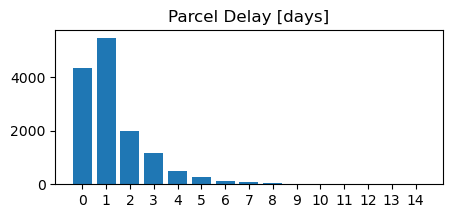

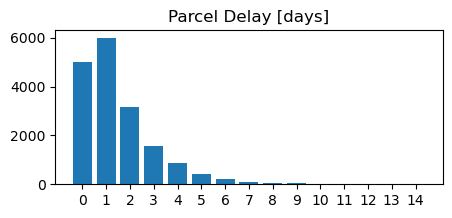

In [129]:
rec8.barplotParcelDelay()
rec9.barplotParcelDelay()
rec10.barplotParcelDelay()
rec11.barplotParcelDelay()


In [130]:
rec8.tableParcelDelay()
rec9.tableParcelDelay()
rec10.tableParcelDelay()
rec11.tableParcelDelay()

Delivery Delay (9998 parcels)
   None:   3695   37.0%
 1 days:   4032   40.3%
 2 days:   1230   12.3%
 3 days:    611    6.1%
 4 days:    231    2.3%
 5 days:    106    1.1%
 6 days:     52    0.5%
 7 days:     18    0.2%
 8 days:     11    0.1%
 9 days:      8    0.1%
10 days:      2    0.0%
11 days:      0    0.0%
12 days:      1    0.0%
13 days:      1    0.0%
Delivery Delay (11963 parcels)
   None:   3807   31.8%
 1 days:   4861   40.6%
 2 days:   1610   13.5%
 3 days:    956    8.0%
 4 days:    380    3.2%
 5 days:    160    1.3%
 6 days:     87    0.7%
 7 days:     63    0.5%
 8 days:     22    0.2%
 9 days:      7    0.1%
10 days:      6    0.1%
11 days:      2    0.0%
12 days:      2    0.0%
Delivery Delay (14019 parcels)
   None:   4337   30.9%
 1 days:   5485   39.1%
 2 days:   1987   14.2%
 3 days:   1178    8.4%
 4 days:    489    3.5%
 5 days:    275    2.0%
 6 days:    117    0.8%
 7 days:     71    0.5%
 8 days:     42    0.3%
 9 days:     17    0.1%
10 days:     16    0

# Running simulations for 45km bike at 4 different p values (0.2,0.24,0.28,0.35)


In [131]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

multiSimulation(range(10), M, W, C, p = 0.20, limit = 45000)
multiSimulation(range(10), M, W, C, p = 0.24, limit = 45000)
multiSimulation(range(10), M, W, C, p = 0.28, limit = 45000)
multiSimulation(range(10), M, W, C, p = 0.35, limit = 45000)

now = datetime.datetime.now()
print (now.strftime("%Y-%m-%d %H:%M:%S"))


Current date and time : 
2023-08-07 10:19:28
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=0
Simulating the delivery of 985 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=1
Simulating the delivery of 993 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=2
Simulating the delivery of 979 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=3
Simulating the delivery of 993 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=4
Simulating the delivery of 982 parcels over 50 days to 100 customers
..................................................
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=5
Simulating th

In [132]:
recs12 = loadSimulations(range(10), p = 0.20, limit = 45000)
recs13 = loadSimulations(range(10), p = 0.24, limit = 45000)
recs14 = loadSimulations(range(10), p = 0.28, limit = 45000)
recs15 = loadSimulations(range(10), p = 0.35, limit = 45000)

rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=0
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=1
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=2
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=3
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=4
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=5
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=6
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=7
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=8
rec days=50 p=0.20 limit=45000 q=0.10 patience=60 seed=9
rec days=50 p=0.24 limit=45000 q=0.10 patience=60 seed=0
rec days=50 p=0.24 limit=45000 q=0.10 patience=60 seed=1
rec days=50 p=0.24 limit=45000 q=0.10 patience=60 seed=2
rec days=50 p=0.24 limit=45000 q=0.10 patience=60 seed=3
rec days=50 p=0.24 limit=45000 q=0.10 patience=60 seed=4
rec days=50 p=0.24 limit=45000 q=0.10 patience=60 seed=5
rec days=50 p=0.24 limit=45000 q=0.10 patience=60 seed=6
rec days=50 p=0.24 limit=45000 

In [133]:
rec12 = combineRecorders(recs12)
rec13 = combineRecorders(recs13)
rec14 = combineRecorders(recs14)
rec15 = combineRecorders(recs15)

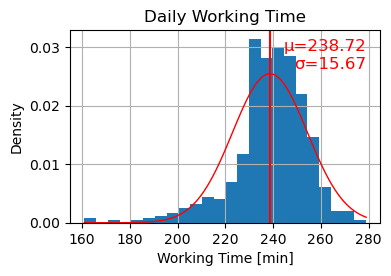

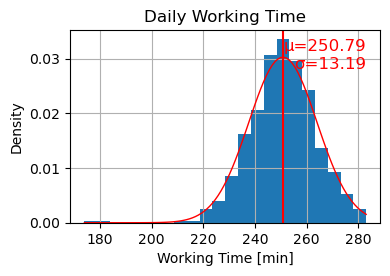

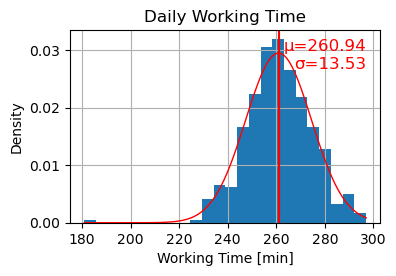

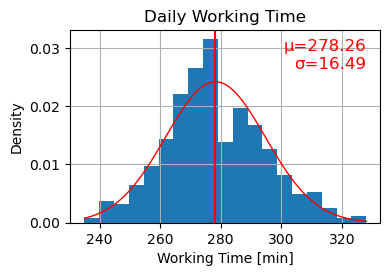

In [134]:
rec12.histWorkingTime()
rec13.histWorkingTime()
rec14.histWorkingTime()
rec15.histWorkingTime()

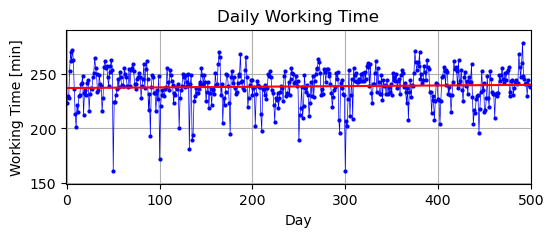

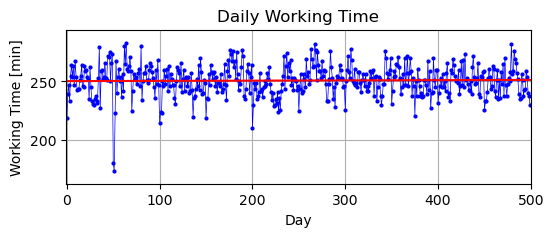

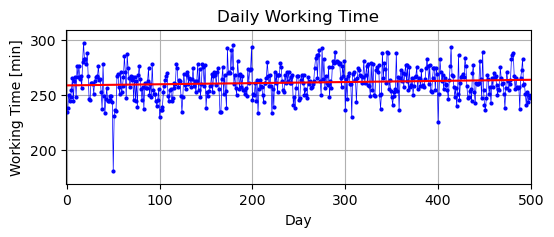

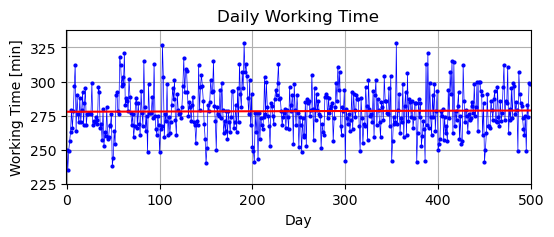

In [135]:
rec12.plotWorkingTime()
rec13.plotWorkingTime()
rec14.plotWorkingTime()
rec15.plotWorkingTime()

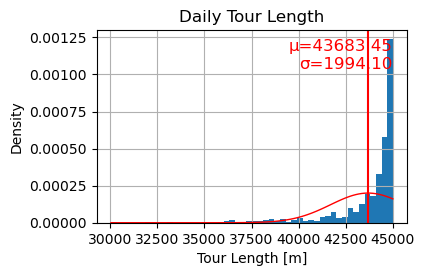

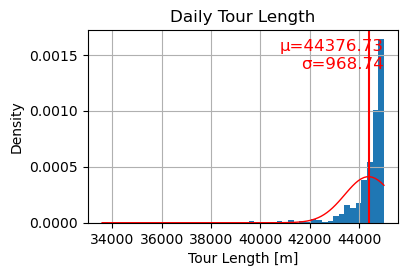

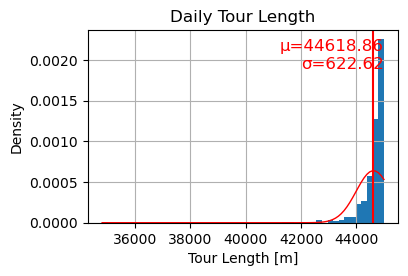

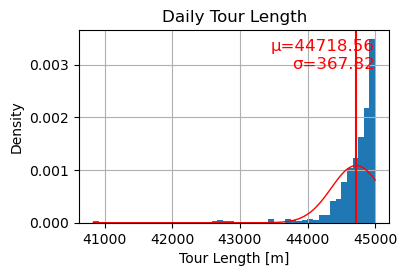

In [136]:
rec12.histTourLength()
rec13.histTourLength()
rec14.histTourLength()
rec15.histTourLength()

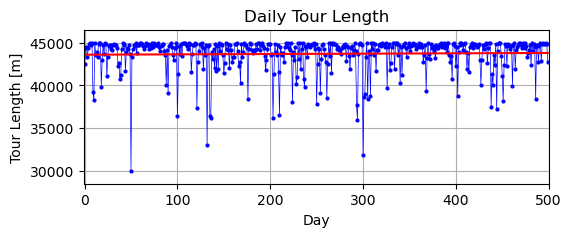

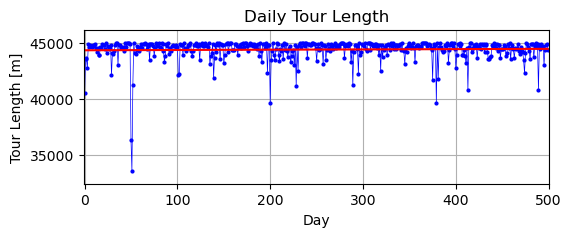

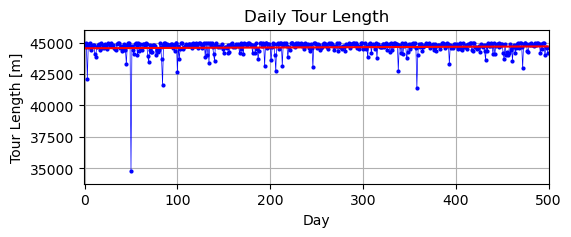

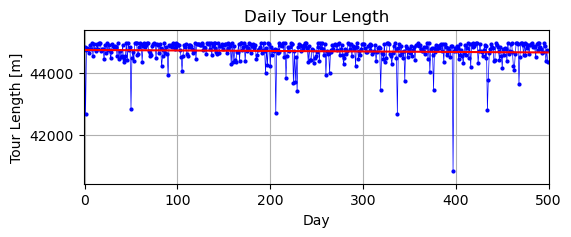

In [137]:
rec12.plotTourLength()
rec13.plotTourLength()
rec14.plotTourLength()
rec15.plotTourLength()

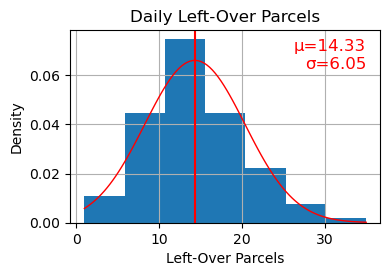

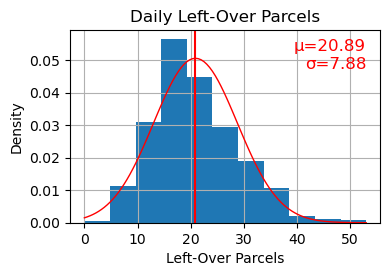

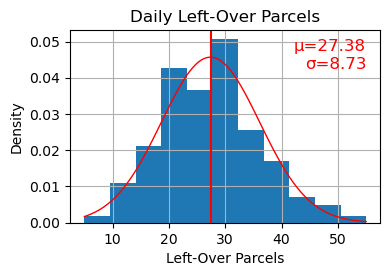

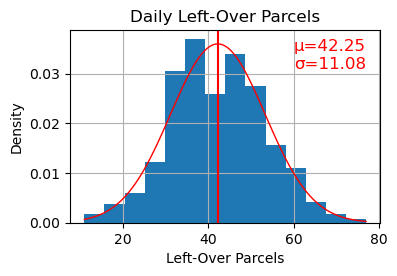

In [138]:
rec12.histLeftOver()
rec13.histLeftOver()
rec14.histLeftOver()
rec15.histLeftOver()

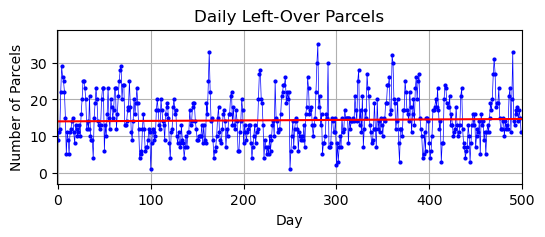

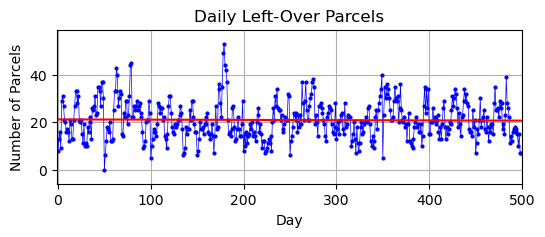

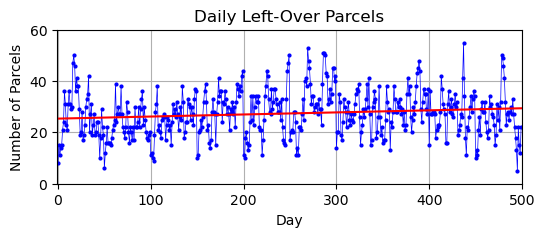

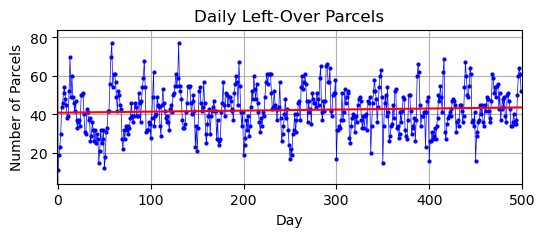

In [139]:
rec12.plotLeftOver()
rec13.plotLeftOver()
rec14.plotLeftOver()
rec15.plotLeftOver()

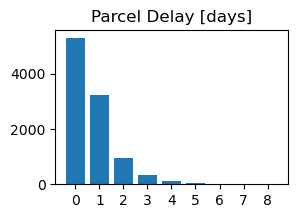

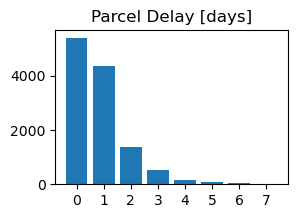

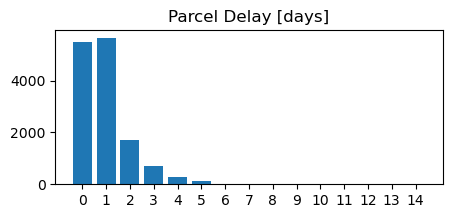

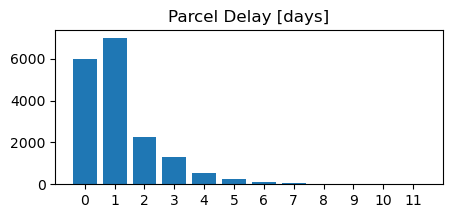

In [140]:
rec12.barplotParcelDelay()
rec13.barplotParcelDelay()
rec14.barplotParcelDelay()
rec15.barplotParcelDelay()


In [141]:
rec12.tableParcelDelay()
rec13.tableParcelDelay()
rec14.tableParcelDelay()
rec15.tableParcelDelay()

Delivery Delay (9998 parcels)
   None:   5305   53.1%
 1 days:   3212   32.1%
 2 days:    966    9.7%
 3 days:    347    3.5%
 4 days:    122    1.2%
 5 days:     36    0.4%
 6 days:      7    0.1%
 7 days:      2    0.0%
 8 days:      1    0.0%
Delivery Delay (11963 parcels)
   None:   5400   45.1%
 1 days:   4357   36.4%
 2 days:   1379   11.5%
 3 days:    538    4.5%
 4 days:    169    1.4%
 5 days:     80    0.7%
 6 days:     33    0.3%
 7 days:      7    0.1%
Delivery Delay (14019 parcels)
   None:   5504   39.3%
 1 days:   5663   40.4%
 2 days:   1699   12.1%
 3 days:    720    5.1%
 4 days:    263    1.9%
 5 days:    111    0.8%
 6 days:     29    0.2%
 7 days:     10    0.1%
 8 days:     12    0.1%
 9 days:      1    0.0%
10 days:      1    0.0%
11 days:      0    0.0%
12 days:      3    0.0%
13 days:      1    0.0%
14 days:      2    0.0%
Delivery Delay (17526 parcels)
   None:   5983   34.1%
 1 days:   7005   40.0%
 2 days:   2248   12.8%
 3 days:   1280    7.3%
 4 days:    5